## CUB dataset Preprocessing

In [31]:
import skimage.io as io
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import scipy
import torchvision.transforms as transforms
%matplotlib inline
import keras
from keras.preprocessing.text import Tokenizer
import skimage.io as io
import scipy
import nltk
import re
import os, sys
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_path = "CUB_200_2011/CUB_200_2011/images/"
data_path_texts = "CUB_200_2011/birds/text_c10/"

In [11]:
names = []
data_dict = [] # name : np.array(pic)
test_dict=[]
black_and_white = []
data_texts = [] # name : text

### Data augmentation 

##### Define transforms

In [72]:
transform_image=transforms.Compose([transforms.ToPILImage(),transforms.RandomAffine((0,10)),transforms.RandomHorizontalFlip(1)])

In [73]:
def augment_dataset(arr, aug_idx):
    massive_array=[]
    for i in range(arr.shape[0]):
        massive_array.append(arr[i])
        for _ in range(aug_idx-1):
            massive_array.append(np.array(transform_image(arr[i])))
    return massive_array

In [81]:
def augment_dataset_text(arr, aug_idx):
    massive_array=[]
    for i in range(arr.shape[0]):
        massive_array.append(arr[i])
        for _ in range(aug_idx-1):
            massive_array.append(arr[i])
    return massive_array

In [12]:
f = open("CUB_200_2011/CUB_200_2011/bounding_boxes.txt",'r')

### Text preprocessing functions

In [32]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(nltk.corpus.stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    # lowercase text
    text = text.lower()
    # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    # delete symbols which are in BAD_SYMBOLS_RE from text
    text = BAD_SYMBOLS_RE.sub('',text)
    # delete stopwords from text
    text = ' '.join([i for i in text.split() if (i not in STOPWORDS) and (i!='color') and (i!='bird')])
    return text

### Build dataset

### Read the names of the files in the right order 

The "images.txt" file contains the names in the files in the correct order - which corresponds to the order of the bounding boxes, which gets violated if the image files were to be opened in a sorted order, different from the one in "images.txt"

In [13]:
f_files = open("CUB_200_2011/CUB_200_2011/images.txt",'r')
f_sets = open("CUB_200_2011/CUB_200_2011/train_test_split.txt",'r')

Build the image dataset

In [14]:
n_pix_train = 0
n_pix  = 0
for file in f_files.readlines():
    pic = file.split(' ')[1]
    img = io.imread(data_path+pic[:-1])
    l = next(f).split(' ')
    print(l)
    
    # use the preprocessing pipeline of StackGAN to get higher object to full image ratio
    imsiz = img.shape  # [height, width, channel]
    center_x = int((2 * int(l[1][:-2]) + int(l[3][:-2])) / 2)
    center_y = int((2 * int(l[2][:-2]) + int(l[4][:-3])) / 2)
    R = int(np.maximum(int(l[3][:-2]), int(l[4][:-3])) * 0.75)
    y1 = np.maximum(0, center_y - R)
    y2 = np.minimum(imsiz[0], center_y + R)
    x1 = np.maximum(0, center_x - R)
    x2 = np.minimum(imsiz[1], center_x + R)
    print(pic)
    
    try:
        img_cropped = img[y1:y2, x1:x2, :]

    except IndexError:
        black_and_white.append(pic[:-4])
        continue
    try:
        img_cropped = scipy.misc.imresize(img_cropped,(64,64),'bicubic')
    except ValueError:
        black_and_white.append(pic[:-4])
        continue
    data_dict.append(img_cropped)
    names.append(pic[:-4])
    n_pix += 1

print("total number of pictures loaded: ",n_pix )

['1', '60.0', '27.0', '325.0', '304.0\n']
001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg

['2', '139.0', '30.0', '153.0', '264.0\n']
001.Black_footed_Albatross/Black_Footed_Albatross_0009_34.jpg

['3', '14.0', '112.0', '388.0', '186.0\n']
001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.jpg

['4', '112.0', '90.0', '255.0', '242.0\n']
001.Black_footed_Albatross/Black_Footed_Albatross_0074_59.jpg

['5', '70.0', '50.0', '134.0', '303.0\n']
001.Black_footed_Albatross/Black_Footed_Albatross_0014_89.jpg

['6', '33.0', '53.0', '251.0', '395.0\n']
001.Black_footed_Albatross/Black_Footed_Albatross_0085_92.jpg

['7', '7.0', '75.0', '420.0', '262.0\n']
001.Black_footed_Albatross/Black_Footed_Albatross_0031_100.jpg

['8', '78.0', '86.0', '333.0', '158.0\n']
001.Black_footed_Albatross/Black_Footed_Albatross_0051_796103.jpg

['9', '112.0', '76.0', '221.0', '189.0\n']
001.Black_footed_Albatross/Black_Footed_Albatross_0010_796097.jpg

['10', '27.0', '4.0', '199.0', '201.0\n']
0

/home/ek/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


['36', '72.0', '40.0', '286.0', '225.0\n']
001.Black_footed_Albatross/Black_Footed_Albatross_0057_796106.jpg

['37', '216.0', '119.0', '221.0', '154.0\n']
001.Black_footed_Albatross/Black_Footed_Albatross_0041_796108.jpg

['38', '40.0', '4.0', '368.0', '445.0\n']
001.Black_footed_Albatross/Black_Footed_Albatross_0053_796109.jpg

['39', '69.0', '57.0', '199.0', '141.0\n']
001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg

['40', '130.0', '29.0', '202.0', '393.0\n']
001.Black_footed_Albatross/Black_Footed_Albatross_0071_796113.jpg

['41', '53.0', '46.0', '302.0', '317.0\n']
001.Black_footed_Albatross/Black_Footed_Albatross_0077_796114.jpg

['42', '25.0', '17.0', '368.0', '299.0\n']
001.Black_footed_Albatross/Black_Footed_Albatross_0032_796115.jpg

['43', '137.0', '64.0', '287.0', '156.0\n']
001.Black_footed_Albatross/Black_Footed_Albatross_0038_212.jpg

['44', '111.0', '42.0', '133.0', '219.0\n']
001.Black_footed_Albatross/Black_Footed_Albatross_0037_796120.jpg

['45', '5

['128', '55.0', '49.0', '176.0', '150.0\n']
003.Sooty_Albatross/Sooty_Albatross_0063_1101.jpg

['129', '206.0', '107.0', '140.0', '115.0\n']
003.Sooty_Albatross/Sooty_Albatross_0044_1105.jpg

['130', '98.0', '24.0', '240.0', '313.0\n']
003.Sooty_Albatross/Sooty_Albatross_0071_1116.jpg

['131', '114.0', '30.0', '205.0', '281.0\n']
003.Sooty_Albatross/Sooty_Albatross_0070_796346.jpg

['132', '75.0', '2.0', '397.0', '330.0\n']
003.Sooty_Albatross/Sooty_Albatross_0030_1122.jpg

['133', '86.0', '57.0', '130.0', '270.0\n']
003.Sooty_Albatross/Sooty_Albatross_0054_796347.jpg

['134', '49.0', '75.0', '366.0', '157.0\n']
003.Sooty_Albatross/Sooty_Albatross_0033_1128.jpg

['135', '33.0', '118.0', '235.0', '173.0\n']
003.Sooty_Albatross/Sooty_Albatross_0048_1130.jpg

['136', '121.0', '74.0', '149.0', '134.0\n']
003.Sooty_Albatross/Sooty_Albatross_0032_1149.jpg

['137', '134.0', '96.0', '123.0', '289.0\n']
003.Sooty_Albatross/Sooty_Albatross_0034_1154.jpg

['138', '165.0', '34.0', '288.0', '296.0\

['217', '143.0', '70.0', '166.0', '255.0\n']
004.Groove_billed_Ani/Groove_Billed_Ani_0074_1730.jpg

['218', '110.0', '67.0', '389.0', '233.0\n']
004.Groove_billed_Ani/Groove_Billed_Ani_0044_1731.jpg

['219', '187.0', '60.0', '134.0', '255.0\n']
004.Groove_billed_Ani/Groove_Billed_Ani_0059_1480.jpg

['220', '110.0', '75.0', '128.0', '256.0\n']
004.Groove_billed_Ani/Groove_Billed_Ani_0023_1485.jpg

['221', '290.0', '97.0', '145.0', '142.0\n']
004.Groove_billed_Ani/Groove_Billed_Ani_0004_1528.jpg

['222', '45.0', '43.0', '270.0', '342.0\n']
004.Groove_billed_Ani/Groove_Billed_Ani_0056_1493.jpg

['223', '58.0', '54.0', '441.0', '320.0\n']
004.Groove_billed_Ani/Groove_Billed_Ani_0005_1750.jpg

['224', '160.0', '65.0', '156.0', '234.0\n']
004.Groove_billed_Ani/Groove_Billed_Ani_0058_1751.jpg

['225', '89.0', '34.0', '228.0', '339.0\n']
004.Groove_billed_Ani/Groove_Billed_Ani_0027_1754.jpg

['226', '94.0', '22.0', '222.0', '470.0\n']
004.Groove_billed_Ani/Groove_Billed_Ani_0014_1755.jpg

['22

['322', '134.0', '74.0', '132.0', '162.0\n']
006.Least_Auklet/Least_Auklet_0038_795132.jpg

['323', '21.0', '10.0', '389.0', '461.0\n']
006.Least_Auklet/Least_Auklet_0063_795134.jpg

['324', '71.0', '77.0', '268.0', '344.0\n']
007.Parakeet_Auklet/Parakeet_Auklet_0004_795921.jpg

['325', '138.0', '55.0', '338.0', '259.0\n']
007.Parakeet_Auklet/Parakeet_Auklet_0017_795924.jpg

['326', '56.0', '89.0', '189.0', '373.0\n']
007.Parakeet_Auklet/Parakeet_Auklet_0027_795925.jpg

['327', '13.0', '42.0', '349.0', '312.0\n']
007.Parakeet_Auklet/Parakeet_Auklet_0056_795926.jpg

['328', '106.0', '92.0', '197.0', '288.0\n']
007.Parakeet_Auklet/Parakeet_Auklet_0012_795927.jpg

['329', '194.0', '139.0', '111.0', '245.0\n']
007.Parakeet_Auklet/Parakeet_Auklet_0072_795929.jpg

['330', '71.0', '66.0', '146.0', '228.0\n']
007.Parakeet_Auklet/Parakeet_Auklet_0030_795930.jpg

['331', '117.0', '45.0', '106.0', '188.0\n']
007.Parakeet_Auklet/Parakeet_Auklet_0007_795932.jpg

['332', '40.0', '22.0', '113.0', '15

['426', '7.0', '122.0', '296.0', '364.0\n']
009.Brewer_Blackbird/Brewer_Blackbird_0139_2567.jpg

['427', '90.0', '77.0', '192.0', '313.0\n']
009.Brewer_Blackbird/Brewer_Blackbird_0140_2586.jpg

['428', '77.0', '41.0', '245.0', '285.0\n']
009.Brewer_Blackbird/Brewer_Blackbird_0082_2593.jpg

['429', '90.0', '119.0', '181.0', '310.0\n']
009.Brewer_Blackbird/Brewer_Blackbird_0135_2607.jpg

['430', '104.0', '120.0', '199.0', '158.0\n']
009.Brewer_Blackbird/Brewer_Blackbird_0106_2608.jpg

['431', '76.0', '77.0', '293.0', '275.0\n']
009.Brewer_Blackbird/Brewer_Blackbird_0095_2610.jpg

['432', '73.0', '72.0', '410.0', '192.0\n']
009.Brewer_Blackbird/Brewer_Blackbird_0035_2611.jpg

['433', '117.0', '48.0', '324.0', '205.0\n']
009.Brewer_Blackbird/Brewer_Blackbird_0111_2613.jpg

['434', '102.0', '104.0', '327.0', '180.0\n']
009.Brewer_Blackbird/Brewer_Blackbird_0009_2616.jpg

['435', '201.0', '114.0', '236.0', '191.0\n']
009.Brewer_Blackbird/Brewer_Blackbird_0102_2620.jpg

['436', '192.0', '181.

['510', '72.0', '53.0', '415.0', '182.0\n']
010.Red_winged_Blackbird/Red_Winged_Blackbird_0007_3706.jpg

['511', '116.0', '81.0', '256.0', '193.0\n']
010.Red_winged_Blackbird/Red_Winged_Blackbird_0012_6015.jpg

['512', '60.0', '68.0', '265.0', '367.0\n']
010.Red_winged_Blackbird/Red_Winged_Blackbird_0013_5762.jpg

['513', '115.0', '106.0', '185.0', '338.0\n']
010.Red_winged_Blackbird/Red_Winged_Blackbird_0062_4233.jpg

['514', '82.0', '92.0', '317.0', '365.0\n']
010.Red_winged_Blackbird/Red_Winged_Blackbird_0099_3985.jpg

['515', '108.0', '39.0', '124.0', '173.0\n']
010.Red_winged_Blackbird/Red_Winged_Blackbird_0046_4242.jpg

['516', '2.0', '58.0', '477.0', '258.0\n']
010.Red_winged_Blackbird/Red_Winged_Blackbird_0071_3988.jpg

['517', '200.0', '75.0', '219.0', '242.0\n']
010.Red_winged_Blackbird/Red_Winged_Blackbird_0027_4123.jpg

['518', '36.0', '97.0', '296.0', '328.0\n']
010.Red_winged_Blackbird/Red_Winged_Blackbird_0032_4004.jpg

['519', '41.0', '28.0', '438.0', '274.0\n']
010.Red

['593', '210.0', '120.0', '156.0', '149.0\n']
011.Rusty_Blackbird/Rusty_Blackbird_0108_6867.jpg

['594', '102.0', '49.0', '147.0', '133.0\n']
011.Rusty_Blackbird/Rusty_Blackbird_0080_6877.jpg

['595', '87.0', '68.0', '195.0', '156.0\n']
011.Rusty_Blackbird/Rusty_Blackbird_0033_6879.jpg

['596', '195.0', '92.0', '207.0', '138.0\n']
011.Rusty_Blackbird/Rusty_Blackbird_0101_6880.jpg

['597', '181.0', '156.0', '184.0', '109.0\n']
011.Rusty_Blackbird/Rusty_Blackbird_0015_6885.jpg

['598', '127.0', '142.0', '366.0', '182.0\n']
011.Rusty_Blackbird/Rusty_Blackbird_0048_6632.jpg

['599', '84.0', '26.0', '238.0', '148.0\n']
011.Rusty_Blackbird/Rusty_Blackbird_0093_6628.jpg

['600', '152.0', '136.0', '287.0', '200.0\n']
011.Rusty_Blackbird/Rusty_Blackbird_0121_6637.jpg

['601', '118.0', '117.0', '179.0', '196.0\n']
011.Rusty_Blackbird/Rusty_Blackbird_0032_6611.jpg

['602', '138.0', '106.0', '281.0', '124.0\n']
011.Rusty_Blackbird/Rusty_Blackbird_0013_6902.jpg

['603', '140.0', '14.0', '334.0', '1

['672', '99.0', '125.0', '194.0', '291.0\n']
013.Bobolink/Bobolink_0050_9821.jpg

['673', '161.0', '93.0', '123.0', '121.0\n']
013.Bobolink/Bobolink_0074_9311.jpg

['674', '295.0', '111.0', '130.0', '183.0\n']
013.Bobolink/Bobolink_0120_10859.jpg

['675', '167.0', '107.0', '128.0', '152.0\n']
013.Bobolink/Bobolink_0097_10861.jpg

['676', '84.0', '228.0', '139.0', '157.0\n']
013.Bobolink/Bobolink_0109_9869.jpg

['677', '171.0', '127.0', '144.0', '212.0\n']
013.Bobolink/Bobolink_0013_9367.jpg

['678', '5.0', '71.0', '235.0', '258.0\n']
013.Bobolink/Bobolink_0065_9375.jpg

['679', '171.0', '117.0', '100.0', '102.0\n']
013.Bobolink/Bobolink_0018_9402.jpg

['680', '76.0', '115.0', '217.0', '307.0\n']
013.Bobolink/Bobolink_0119_10430.jpg

['681', '149.0', '136.0', '168.0', '167.0\n']
013.Bobolink/Bobolink_0126_11458.jpg

['682', '178.0', '80.0', '182.0', '131.0\n']
013.Bobolink/Bobolink_0052_9423.jpg

['683', '248.0', '65.0', '133.0', '151.0\n']
013.Bobolink/Bobolink_0081_9439.jpg

['684', '

['780', '51.0', '77.0', '312.0', '226.0\n']
015.Lazuli_Bunting/Lazuli_Bunting_0073_14594.jpg

['781', '199.0', '95.0', '194.0', '231.0\n']
015.Lazuli_Bunting/Lazuli_Bunting_0074_14854.jpg

['782', '61.0', '68.0', '178.0', '192.0\n']
015.Lazuli_Bunting/Lazuli_Bunting_0102_14605.jpg

['783', '139.0', '123.0', '190.0', '249.0\n']
015.Lazuli_Bunting/Lazuli_Bunting_0047_14863.jpg

['784', '29.0', '47.0', '229.0', '177.0\n']
015.Lazuli_Bunting/Lazuli_Bunting_0034_14864.jpg

['785', '37.0', '151.0', '287.0', '210.0\n']
015.Lazuli_Bunting/Lazuli_Bunting_0101_14873.jpg

['786', '184.0', '27.0', '169.0', '176.0\n']
015.Lazuli_Bunting/Lazuli_Bunting_0052_14618.jpg

['787', '112.0', '93.0', '250.0', '331.0\n']
015.Lazuli_Bunting/Lazuli_Bunting_0085_14627.jpg

['788', '27.0', '58.0', '222.0', '243.0\n']
015.Lazuli_Bunting/Lazuli_Bunting_0089_14598.jpg

['789', '216.0', '159.0', '147.0', '266.0\n']
015.Lazuli_Bunting/Lazuli_Bunting_0004_14887.jpg

['790', '71.0', '89.0', '282.0', '148.0\n']
015.Lazu

['883', '75.0', '38.0', '386.0', '277.0\n']
016.Painted_Bunting/Painted_Bunting_0085_15282.jpg

['884', '105.0', '78.0', '207.0', '218.0\n']
016.Painted_Bunting/Painted_Bunting_0036_16563.jpg

['885', '83.0', '93.0', '132.0', '293.0\n']
016.Painted_Bunting/Painted_Bunting_0078_16565.jpg

['886', '89.0', '96.0', '286.0', '183.0\n']
016.Painted_Bunting/Painted_Bunting_0013_15294.jpg

['887', '209.0', '79.0', '139.0', '244.0\n']
016.Painted_Bunting/Painted_Bunting_0021_15295.jpg

['888', '168.0', '156.0', '102.0', '123.0\n']
016.Painted_Bunting/Painted_Bunting_0001_16585.jpg

['889', '224.0', '114.0', '121.0', '158.0\n']
016.Painted_Bunting/Painted_Bunting_0083_16587.jpg

['890', '179.0', '69.0', '160.0', '211.0\n']
016.Painted_Bunting/Painted_Bunting_0009_16674.jpg

['891', '114.0', '25.0', '192.0', '251.0\n']
016.Painted_Bunting/Painted_Bunting_0056_16599.jpg

['892', '73.0', '81.0', '241.0', '203.0\n']
016.Painted_Bunting/Painted_Bunting_0032_16605.jpg

['893', '159.0', '78.0', '190.0'

['994', '43.0', '69.0', '330.0', '277.0\n']
018.Spotted_Catbird/Spotted_Catbird_0027_796796.jpg

['995', '46.0', '41.0', '163.0', '270.0\n']
018.Spotted_Catbird/Spotted_Catbird_0001_796797.jpg

['996', '66.0', '67.0', '268.0', '430.0\n']
018.Spotted_Catbird/Spotted_Catbird_0021_796798.jpg

['997', '35.0', '29.0', '179.0', '218.0\n']
018.Spotted_Catbird/Spotted_Catbird_0035_796799.jpg

['998', '86.0', '87.0', '201.0', '161.0\n']
019.Gray_Catbird/Gray_Catbird_0043_21008.jpg

['999', '2.0', '69.0', '457.0', '311.0\n']
019.Gray_Catbird/Gray_Catbird_0032_21551.jpg

['1000', '202.0', '69.0', '197.0', '253.0\n']
019.Gray_Catbird/Gray_Catbird_0067_21043.jpg

['1001', '75.0', '81.0', '310.0', '311.0\n']
019.Gray_Catbird/Gray_Catbird_0039_21040.jpg

['1002', '96.0', '90.0', '148.0', '191.0\n']
019.Gray_Catbird/Gray_Catbird_0127_20034.jpg

['1003', '106.0', '62.0', '169.0', '409.0\n']
019.Gray_Catbird/Gray_Catbird_0069_21065.jpg

['1004', '112.0', '82.0', '338.0', '321.0\n']
019.Gray_Catbird/Gray

['1101', '23.0', '133.0', '282.0', '160.0\n']
020.Yellow_breasted_Chat/Yellow_Breasted_Chat_0107_21698.jpg

['1102', '55.0', '161.0', '240.0', '194.0\n']
020.Yellow_breasted_Chat/Yellow_Breasted_Chat_0034_21955.jpg

['1103', '98.0', '94.0', '273.0', '198.0\n']
020.Yellow_breasted_Chat/Yellow_Breasted_Chat_0012_21961.jpg

['1104', '109.0', '195.0', '149.0', '186.0\n']
020.Yellow_breasted_Chat/Yellow_Breasted_Chat_0030_21964.jpg

['1105', '132.0', '46.0', '171.0', '197.0\n']
020.Yellow_breasted_Chat/Yellow_Breasted_Chat_0061_21967.jpg

['1106', '223.0', '67.0', '177.0', '166.0\n']
020.Yellow_breasted_Chat/Yellow_Breasted_Chat_0105_21714.jpg

['1107', '59.0', '107.0', '295.0', '392.0\n']
020.Yellow_breasted_Chat/Yellow_Breasted_Chat_0075_21715.jpg

['1108', '123.0', '18.0', '183.0', '305.0\n']
020.Yellow_breasted_Chat/Yellow_Breasted_Chat_0017_21719.jpg

['1109', '25.0', '31.0', '217.0', '241.0\n']
020.Yellow_breasted_Chat/Yellow_Breasted_Chat_0079_21978.jpg

['1110', '245.0', '121.0', '1

['1208', '25.0', '52.0', '295.0', '216.0\n']
022.Chuck_will_Widow/Chuck_Will_Widow_0018_796980.jpg

['1209', '37.0', '95.0', '441.0', '161.0\n']
022.Chuck_will_Widow/Chuck_Will_Widow_0031_796981.jpg

['1210', '23.0', '76.0', '421.0', '257.0\n']
022.Chuck_will_Widow/Chuck_Will_Widow_0059_796982.jpg

['1211', '9.0', '14.0', '343.0', '274.0\n']
022.Chuck_will_Widow/Chuck_Will_Widow_0042_796983.jpg

['1212', '7.0', '47.0', '324.0', '365.0\n']
022.Chuck_will_Widow/Chuck_Will_Widow_0052_796984.jpg

['1213', '54.0', '60.0', '445.0', '273.0\n']
022.Chuck_will_Widow/Chuck_Will_Widow_0035_796985.jpg

['1214', '16.0', '80.0', '420.0', '199.0\n']
022.Chuck_will_Widow/Chuck_Will_Widow_0006_796986.jpg

['1215', '159.0', '51.0', '264.0', '239.0\n']
022.Chuck_will_Widow/Chuck_Will_Widow_0014_796987.jpg

['1216', '107.0', '61.0', '392.0', '230.0\n']
022.Chuck_will_Widow/Chuck_Will_Widow_0028_796988.jpg

['1217', '1.0', '5.0', '340.0', '234.0\n']
022.Chuck_will_Widow/Chuck_Will_Widow_0038_796989.jpg

['

['1323', '55.0', '8.0', '156.0', '338.0\n']
024.Red_faced_Cormorant/Red_Faced_Cormorant_0020_796318.jpg

['1324', '99.0', '63.0', '104.0', '131.0\n']
024.Red_faced_Cormorant/Red_Faced_Cormorant_0070_796319.jpg

['1325', '46.0', '35.0', '292.0', '235.0\n']
024.Red_faced_Cormorant/Red_Faced_Cormorant_0068_796321.jpg

['1326', '58.0', '58.0', '180.0', '382.0\n']
024.Red_faced_Cormorant/Red_Faced_Cormorant_0028_796322.jpg

['1327', '108.0', '74.0', '126.0', '249.0\n']
024.Red_faced_Cormorant/Red_Faced_Cormorant_0017_796323.jpg

['1328', '78.0', '78.0', '304.0', '165.0\n']
024.Red_faced_Cormorant/Red_Faced_Cormorant_0045_796324.jpg

['1329', '44.0', '71.0', '199.0', '428.0\n']
024.Red_faced_Cormorant/Red_Faced_Cormorant_0030_796325.jpg

['1330', '190.0', '122.0', '175.0', '264.0\n']
024.Red_faced_Cormorant/Red_Faced_Cormorant_0001_796327.jpg

['1331', '177.0', '114.0', '125.0', '218.0\n']
024.Red_faced_Cormorant/Red_Faced_Cormorant_0064_23464.jpg

['1332', '1.0', '55.0', '165.0', '214.0\n']

['1408', '74.0', '111.0', '297.0', '255.0\n']
026.Bronzed_Cowbird/Bronzed_Cowbird_0060_24082.jpg

['1409', '38.0', '49.0', '396.0', '448.0\n']
026.Bronzed_Cowbird/Bronzed_Cowbird_0051_24083.jpg

['1410', '52.0', '103.0', '225.0', '319.0\n']
026.Bronzed_Cowbird/Bronzed_Cowbird_0030_24103.jpg

['1411', '101.0', '63.0', '165.0', '235.0\n']
026.Bronzed_Cowbird/Bronzed_Cowbird_0034_796209.jpg

['1412', '36.0', '71.0', '357.0', '284.0\n']
026.Bronzed_Cowbird/Bronzed_Cowbird_0091_796212.jpg

['1413', '126.0', '68.0', '151.0', '405.0\n']
026.Bronzed_Cowbird/Bronzed_Cowbird_0025_796213.jpg

['1414', '95.0', '72.0', '280.0', '170.0\n']
026.Bronzed_Cowbird/Bronzed_Cowbird_0092_796215.jpg

['1415', '172.0', '113.0', '188.0', '167.0\n']
026.Bronzed_Cowbird/Bronzed_Cowbird_0052_796216.jpg

['1416', '25.0', '16.0', '183.0', '151.0\n']
026.Bronzed_Cowbird/Bronzed_Cowbird_0046_796218.jpg

['1417', '148.0', '62.0', '323.0', '311.0\n']
026.Bronzed_Cowbird/Bronzed_Cowbird_0001_796219.jpg

['1418', '78.0',

['1517', '174.0', '102.0', '143.0', '134.0\n']
027.Shiny_Cowbird/Shiny_Cowbird_0020_24276.jpg

['1518', '120.0', '69.0', '268.0', '189.0\n']
027.Shiny_Cowbird/Shiny_Cowbird_0082_24279.jpg

['1519', '200.0', '152.0', '176.0', '130.0\n']
027.Shiny_Cowbird/Shiny_Cowbird_0024_24281.jpg

['1520', '49.0', '45.0', '284.0', '248.0\n']
027.Shiny_Cowbird/Shiny_Cowbird_0005_796873.jpg

['1521', '106.0', '58.0', '290.0', '175.0\n']
027.Shiny_Cowbird/Shiny_Cowbird_0032_24284.jpg

['1522', '156.0', '56.0', '225.0', '252.0\n']
027.Shiny_Cowbird/Shiny_Cowbird_0074_24297.jpg

['1523', '153.0', '134.0', '129.0', '285.0\n']
028.Brown_Creeper/Brown_Creeper_0042_24578.jpg

['1524', '156.0', '35.0', '187.0', '299.0\n']
028.Brown_Creeper/Brown_Creeper_0093_24581.jpg

['1525', '137.0', '79.0', '124.0', '420.0\n']
028.Brown_Creeper/Brown_Creeper_0123_24589.jpg

['1526', '282.0', '54.0', '149.0', '355.0\n']
028.Brown_Creeper/Brown_Creeper_0111_24590.jpg

['1527', '95.0', '89.0', '149.0', '342.0\n']
028.Brown_Cr

['1612', '55.0', '57.0', '339.0', '266.0\n']
029.American_Crow/American_Crow_0050_25255.jpg

['1613', '229.0', '106.0', '104.0', '106.0\n']
029.American_Crow/American_Crow_0085_25260.jpg

['1614', '186.0', '90.0', '244.0', '314.0\n']
029.American_Crow/American_Crow_0105_25283.jpg

['1615', '133.0', '22.0', '294.0', '255.0\n']
029.American_Crow/American_Crow_0014_25287.jpg

['1616', '118.0', '101.0', '221.0', '167.0\n']
029.American_Crow/American_Crow_0088_25303.jpg

['1617', '133.0', '71.0', '244.0', '218.0\n']
029.American_Crow/American_Crow_0012_25305.jpg

['1618', '14.0', '51.0', '462.0', '334.0\n']
029.American_Crow/American_Crow_0004_25819.jpg

['1619', '73.0', '87.0', '312.0', '246.0\n']
029.American_Crow/American_Crow_0036_25313.jpg

['1620', '51.0', '39.0', '380.0', '264.0\n']
029.American_Crow/American_Crow_0081_25837.jpg

['1621', '28.0', '29.0', '441.0', '267.0\n']
029.American_Crow/American_Crow_0074_25350.jpg

['1622', '76.0', '101.0', '325.0', '162.0\n']
029.American_Crow

['1719', '32.0', '132.0', '300.0', '312.0\n']
031.Black_billed_Cuckoo/Black_Billed_Cuckoo_0017_26221.jpg

['1720', '14.0', '101.0', '254.0', '376.0\n']
031.Black_billed_Cuckoo/Black_Billed_Cuckoo_0077_26222.jpg

['1721', '28.0', '94.0', '313.0', '350.0\n']
031.Black_billed_Cuckoo/Black_Billed_Cuckoo_0055_26223.jpg

['1722', '202.0', '93.0', '151.0', '197.0\n']
031.Black_billed_Cuckoo/Black_Billed_Cuckoo_0052_26232.jpg

['1723', '197.0', '104.0', '264.0', '233.0\n']
031.Black_billed_Cuckoo/Black_Billed_Cuckoo_0006_26233.jpg

['1724', '107.0', '29.0', '211.0', '345.0\n']
031.Black_billed_Cuckoo/Black_Billed_Cuckoo_0066_26303.jpg

['1725', '114.0', '76.0', '144.0', '423.0\n']
031.Black_billed_Cuckoo/Black_Billed_Cuckoo_0030_26240.jpg

['1726', '172.0', '61.0', '160.0', '189.0\n']
031.Black_billed_Cuckoo/Black_Billed_Cuckoo_0082_26241.jpg

['1727', '119.0', '44.0', '121.0', '331.0\n']
031.Black_billed_Cuckoo/Black_Billed_Cuckoo_0001_26242.jpg

['1728', '72.0', '70.0', '111.0', '330.0\n']
0

['1810', '17.0', '39.0', '287.0', '268.0\n']
032.Mangrove_Cuckoo/Mangrove_Cuckoo_0046_794616.jpg

['1811', '67.0', '63.0', '265.0', '422.0\n']
032.Mangrove_Cuckoo/Mangrove_Cuckoo_0003_794619.jpg

['1812', '59.0', '39.0', '124.0', '219.0\n']
032.Mangrove_Cuckoo/Mangrove_Cuckoo_0013_794620.jpg

['1813', '137.0', '95.0', '220.0', '322.0\n']
032.Mangrove_Cuckoo/Mangrove_Cuckoo_0019_794621.jpg

['1814', '48.0', '37.0', '196.0', '414.0\n']
032.Mangrove_Cuckoo/Mangrove_Cuckoo_0017_794623.jpg

['1815', '94.0', '69.0', '269.0', '348.0\n']
033.Yellow_billed_Cuckoo/Yellow_Billed_Cuckoo_0048_26632.jpg

['1816', '94.0', '138.0', '101.0', '118.0\n']
033.Yellow_billed_Cuckoo/Yellow_Billed_Cuckoo_0023_26637.jpg

['1817', '205.0', '117.0', '160.0', '206.0\n']
033.Yellow_billed_Cuckoo/Yellow_Billed_Cuckoo_0094_26643.jpg

['1818', '99.0', '109.0', '262.0', '168.0\n']
033.Yellow_billed_Cuckoo/Yellow_Billed_Cuckoo_0027_26844.jpg

['1819', '117.0', '116.0', '249.0', '328.0\n']
033.Yellow_billed_Cuckoo/Yello

['1888', '39.0', '27.0', '272.0', '265.0\n']
034.Gray_crowned_Rosy_Finch/Gray_Crowned_Rosy_Finch_0067_797289.jpg

['1889', '97.0', '36.0', '361.0', '430.0\n']
034.Gray_crowned_Rosy_Finch/Gray_Crowned_Rosy_Finch_0061_26979.jpg

['1890', '188.0', '144.0', '116.0', '136.0\n']
034.Gray_crowned_Rosy_Finch/Gray_Crowned_Rosy_Finch_0004_797272.jpg

['1891', '214.0', '78.0', '234.0', '185.0\n']
034.Gray_crowned_Rosy_Finch/Gray_Crowned_Rosy_Finch_0048_27236.jpg

['1892', '143.0', '91.0', '266.0', '249.0\n']
034.Gray_crowned_Rosy_Finch/Gray_Crowned_Rosy_Finch_0025_797274.jpg

['1893', '43.0', '50.0', '306.0', '258.0\n']
034.Gray_crowned_Rosy_Finch/Gray_Crowned_Rosy_Finch_0053_797276.jpg

['1894', '40.0', '62.0', '168.0', '140.0\n']
034.Gray_crowned_Rosy_Finch/Gray_Crowned_Rosy_Finch_0007_797278.jpg

['1895', '104.0', '74.0', '372.0', '218.0\n']
034.Gray_crowned_Rosy_Finch/Gray_Crowned_Rosy_Finch_0044_26976.jpg

['1896', '67.0', '72.0', '205.0', '363.0\n']
034.Gray_crowned_Rosy_Finch/Gray_Crowned_

['1971', '128.0', '57.0', '299.0', '273.0\n']
035.Purple_Finch/Purple_Finch_0049_27507.jpg

['1972', '103.0', '83.0', '176.0', '185.0\n']
035.Purple_Finch/Purple_Finch_0005_27512.jpg

['1973', '100.0', '136.0', '281.0', '210.0\n']
035.Purple_Finch/Purple_Finch_0134_27526.jpg

['1974', '15.0', '95.0', '414.0', '216.0\n']
035.Purple_Finch/Purple_Finch_0053_27543.jpg

['1975', '56.0', '59.0', '264.0', '216.0\n']
035.Purple_Finch/Purple_Finch_0113_27547.jpg

['1976', '33.0', '36.0', '323.0', '263.0\n']
035.Purple_Finch/Purple_Finch_0130_27555.jpg

['1977', '135.0', '253.0', '113.0', '114.0\n']
035.Purple_Finch/Purple_Finch_0011_27633.jpg

['1978', '158.0', '44.0', '261.0', '295.0\n']
035.Purple_Finch/Purple_Finch_0088_28076.jpg

['1979', '148.0', '91.0', '351.0', '231.0\n']
035.Purple_Finch/Purple_Finch_0004_27565.jpg

['1980', '18.0', '147.0', '312.0', '173.0\n']
035.Purple_Finch/Purple_Finch_0124_27567.jpg

['1981', '150.0', '65.0', '186.0', '220.0\n']
035.Purple_Finch/Purple_Finch_0104_

['2079', '110.0', '44.0', '141.0', '119.0\n']
037.Acadian_Flycatcher/Acadian_Flycatcher_0045_795587.jpg

['2080', '52.0', '45.0', '234.0', '431.0\n']
037.Acadian_Flycatcher/Acadian_Flycatcher_0068_795590.jpg

['2081', '19.0', '49.0', '459.0', '371.0\n']
037.Acadian_Flycatcher/Acadian_Flycatcher_0042_29127.jpg

['2082', '182.0', '45.0', '227.0', '276.0\n']
037.Acadian_Flycatcher/Acadian_Flycatcher_0019_795592.jpg

['2083', '90.0', '18.0', '224.0', '444.0\n']
037.Acadian_Flycatcher/Acadian_Flycatcher_0047_795593.jpg

['2084', '198.0', '151.0', '193.0', '133.0\n']
037.Acadian_Flycatcher/Acadian_Flycatcher_0021_795594.jpg

['2085', '40.0', '87.0', '411.0', '359.0\n']
037.Acadian_Flycatcher/Acadian_Flycatcher_0006_795595.jpg

['2086', '99.0', '31.0', '119.0', '213.0\n']
037.Acadian_Flycatcher/Acadian_Flycatcher_0046_795596.jpg

['2087', '70.0', '55.0', '286.0', '313.0\n']
037.Acadian_Flycatcher/Acadian_Flycatcher_0017_795598.jpg

['2088', '25.0', '134.0', '225.0', '292.0\n']
037.Acadian_Fly

['2162', '147.0', '93.0', '160.0', '302.0\n']
038.Great_Crested_Flycatcher/Great_Crested_Flycatcher_0111_29543.jpg

['2163', '182.0', '80.0', '182.0', '151.0\n']
038.Great_Crested_Flycatcher/Great_Crested_Flycatcher_0064_29546.jpg

['2164', '78.0', '14.0', '260.0', '485.0\n']
038.Great_Crested_Flycatcher/Great_Crested_Flycatcher_0074_29553.jpg

['2165', '161.0', '62.0', '121.0', '385.0\n']
038.Great_Crested_Flycatcher/Great_Crested_Flycatcher_0092_29583.jpg

['2166', '137.0', '97.0', '130.0', '240.0\n']
038.Great_Crested_Flycatcher/Great_Crested_Flycatcher_0048_29586.jpg

['2167', '115.0', '100.0', '193.0', '245.0\n']
038.Great_Crested_Flycatcher/Great_Crested_Flycatcher_0089_29592.jpg

['2168', '44.0', '81.0', '282.0', '364.0\n']
038.Great_Crested_Flycatcher/Great_Crested_Flycatcher_0125_29593.jpg

['2169', '38.0', '108.0', '366.0', '274.0\n']
038.Great_Crested_Flycatcher/Great_Crested_Flycatcher_0069_29603.jpg

['2170', '55.0', '93.0', '277.0', '196.0\n']
038.Great_Crested_Flycatcher

['2267', '150.0', '76.0', '226.0', '206.0\n']
040.Olive_sided_Flycatcher/Olive_Sided_Flycatcher_0001_30669.jpg

['2268', '78.0', '112.0', '163.0', '372.0\n']
040.Olive_sided_Flycatcher/Olive_Sided_Flycatcher_0050_796878.jpg

['2269', '35.0', '42.0', '139.0', '238.0\n']
040.Olive_sided_Flycatcher/Olive_Sided_Flycatcher_0055_796879.jpg

['2270', '198.0', '88.0', '299.0', '148.0\n']
040.Olive_sided_Flycatcher/Olive_Sided_Flycatcher_0034_30672.jpg

['2271', '47.0', '44.0', '175.0', '252.0\n']
040.Olive_sided_Flycatcher/Olive_Sided_Flycatcher_0020_796881.jpg

['2272', '101.0', '100.0', '143.0', '272.0\n']
040.Olive_sided_Flycatcher/Olive_Sided_Flycatcher_0018_796882.jpg

['2273', '111.0', '47.0', '102.0', '315.0\n']
040.Olive_sided_Flycatcher/Olive_Sided_Flycatcher_0058_796883.jpg

['2274', '146.0', '65.0', '257.0', '411.0\n']
040.Olive_sided_Flycatcher/Olive_Sided_Flycatcher_0038_796884.jpg

['2275', '263.0', '87.0', '113.0', '306.0\n']
040.Olive_sided_Flycatcher/Olive_Sided_Flycatcher_000

['2353', '121.0', '149.0', '144.0', '146.0\n']
042.Vermilion_Flycatcher/Vermilion_Flycatcher_0069_42502.jpg

['2354', '95.0', '168.0', '140.0', '104.0\n']
042.Vermilion_Flycatcher/Vermilion_Flycatcher_0025_42248.jpg

['2355', '163.0', '169.0', '169.0', '136.0\n']
042.Vermilion_Flycatcher/Vermilion_Flycatcher_0070_42250.jpg

['2356', '173.0', '69.0', '187.0', '245.0\n']
042.Vermilion_Flycatcher/Vermilion_Flycatcher_0012_42253.jpg

['2357', '170.0', '65.0', '304.0', '253.0\n']
042.Vermilion_Flycatcher/Vermilion_Flycatcher_0059_42261.jpg

['2358', '164.0', '187.0', '210.0', '166.0\n']
042.Vermilion_Flycatcher/Vermilion_Flycatcher_0038_42262.jpg

['2359', '48.0', '112.0', '258.0', '271.0\n']
042.Vermilion_Flycatcher/Vermilion_Flycatcher_0042_42266.jpg

['2360', '27.0', '160.0', '254.0', '154.0\n']
042.Vermilion_Flycatcher/Vermilion_Flycatcher_0030_42523.jpg

['2361', '186.0', '76.0', '162.0', '155.0\n']
042.Vermilion_Flycatcher/Vermilion_Flycatcher_0014_42533.jpg

['2362', '201.0', '135.0'

['2443', '307.0', '27.0', '118.0', '253.0\n']
043.Yellow_bellied_Flycatcher/Yellow_Bellied_Flycatcher_0048_795505.jpg

['2444', '99.0', '72.0', '198.0', '333.0\n']
043.Yellow_bellied_Flycatcher/Yellow_Bellied_Flycatcher_0055_795507.jpg

['2445', '12.0', '26.0', '111.0', '172.0\n']
043.Yellow_bellied_Flycatcher/Yellow_Bellied_Flycatcher_0046_795508.jpg

['2446', '171.0', '98.0', '213.0', '267.0\n']
043.Yellow_bellied_Flycatcher/Yellow_Bellied_Flycatcher_0009_795510.jpg

['2447', '35.0', '38.0', '197.0', '222.0\n']
043.Yellow_bellied_Flycatcher/Yellow_Bellied_Flycatcher_0034_795511.jpg

['2448', '166.0', '120.0', '126.0', '321.0\n']
043.Yellow_bellied_Flycatcher/Yellow_Bellied_Flycatcher_0019_795512.jpg

['2449', '39.0', '49.0', '127.0', '221.0\n']
043.Yellow_bellied_Flycatcher/Yellow_Bellied_Flycatcher_0004_795513.jpg

['2450', '191.0', '80.0', '161.0', '192.0\n']
043.Yellow_bellied_Flycatcher/Yellow_Bellied_Flycatcher_0066_795514.jpg

['2451', '152.0', '24.0', '244.0', '453.0\n']
043.Y

['2530', '173.0', '34.0', '168.0', '257.0\n']
045.Northern_Fulmar/Northern_Fulmar_0029_44049.jpg

['2531', '139.0', '81.0', '353.0', '224.0\n']
045.Northern_Fulmar/Northern_Fulmar_0033_43794.jpg

['2532', '107.0', '89.0', '232.0', '142.0\n']
045.Northern_Fulmar/Northern_Fulmar_0103_44062.jpg

['2533', '195.0', '80.0', '139.0', '123.0\n']
045.Northern_Fulmar/Northern_Fulmar_0023_43809.jpg

['2534', '200.0', '114.0', '142.0', '150.0\n']
045.Northern_Fulmar/Northern_Fulmar_0060_43813.jpg

['2535', '67.0', '57.0', '290.0', '142.0\n']
045.Northern_Fulmar/Northern_Fulmar_0065_44081.jpg

['2536', '95.0', '59.0', '294.0', '233.0\n']
045.Northern_Fulmar/Northern_Fulmar_0074_43955.jpg

['2537', '16.0', '54.0', '417.0', '242.0\n']
045.Northern_Fulmar/Northern_Fulmar_0098_43578.jpg

['2538', '120.0', '158.0', '167.0', '203.0\n']
045.Northern_Fulmar/Northern_Fulmar_0045_43581.jpg

['2539', '65.0', '69.0', '182.0', '145.0\n']
045.Northern_Fulmar/Northern_Fulmar_0050_43839.jpg

['2540', '115.0', '34.

['2639', '76.0', '62.0', '368.0', '147.0\n']
046.Gadwall/Gadwall_0070_31187.jpg

['2640', '160.0', '66.0', '247.0', '129.0\n']
046.Gadwall/Gadwall_0025_30933.jpg

['2641', '20.0', '83.0', '357.0', '143.0\n']
046.Gadwall/Gadwall_0031_30935.jpg

['2642', '88.0', '96.0', '299.0', '128.0\n']
046.Gadwall/Gadwall_0049_30936.jpg

['2643', '35.0', '31.0', '387.0', '286.0\n']
046.Gadwall/Gadwall_0091_30941.jpg

['2644', '132.0', '66.0', '203.0', '182.0\n']
046.Gadwall/Gadwall_0024_30942.jpg

['2645', '157.0', '122.0', '299.0', '104.0\n']
046.Gadwall/Gadwall_0071_31655.jpg

['2646', '123.0', '72.0', '169.0', '139.0\n']
046.Gadwall/Gadwall_0034_31212.jpg

['2647', '22.0', '130.0', '291.0', '114.0\n']
046.Gadwall/Gadwall_0083_30959.jpg

['2648', '108.0', '111.0', '357.0', '104.0\n']
046.Gadwall/Gadwall_0027_30966.jpg

['2649', '73.0', '97.0', '341.0', '146.0\n']
046.Gadwall/Gadwall_0013_31020.jpg

['2650', '39.0', '169.0', '250.0', '206.0\n']
047.American_Goldfinch/American_Goldfinch_0074_32265.jp

['2723', '80.0', '159.0', '223.0', '135.0\n']
048.European_Goldfinch/European_Goldfinch_0093_794653.jpg

['2724', '84.0', '120.0', '126.0', '284.0\n']
048.European_Goldfinch/European_Goldfinch_0107_794655.jpg

['2725', '24.0', '52.0', '112.0', '143.0\n']
048.European_Goldfinch/European_Goldfinch_0048_794656.jpg

['2726', '53.0', '189.0', '195.0', '200.0\n']
048.European_Goldfinch/European_Goldfinch_0004_33313.jpg

['2727', '26.0', '33.0', '242.0', '325.0\n']
048.European_Goldfinch/European_Goldfinch_0075_794660.jpg

['2728', '58.0', '50.0', '337.0', '222.0\n']
048.European_Goldfinch/European_Goldfinch_0006_794661.jpg

['2729', '34.0', '109.0', '358.0', '209.0\n']
048.European_Goldfinch/European_Goldfinch_0103_794664.jpg

['2730', '50.0', '61.0', '160.0', '207.0\n']
048.European_Goldfinch/European_Goldfinch_0058_794665.jpg

['2731', '101.0', '17.0', '248.0', '118.0\n']
048.European_Goldfinch/European_Goldfinch_0080_33322.jpg

['2732', '207.0', '54.0', '245.0', '192.0\n']
048.European_Go

['2809', '191.0', '86.0', '151.0', '185.0\n']
049.Boat_tailed_Grackle/Boat_Tailed_Grackle_0100_33985.jpg

['2810', '20.0', '37.0', '382.0', '322.0\n']
049.Boat_tailed_Grackle/Boat_Tailed_Grackle_0101_33611.jpg

['2811', '143.0', '53.0', '319.0', '214.0\n']
049.Boat_tailed_Grackle/Boat_Tailed_Grackle_0017_33480.jpg

['2812', '101.0', '132.0', '174.0', '319.0\n']
049.Boat_tailed_Grackle/Boat_Tailed_Grackle_0014_33485.jpg

['2813', '233.0', '28.0', '163.0', '210.0\n']
049.Boat_tailed_Grackle/Boat_Tailed_Grackle_0012_33998.jpg

['2814', '13.0', '69.0', '376.0', '345.0\n']
049.Boat_tailed_Grackle/Boat_Tailed_Grackle_0027_33743.jpg

['2815', '82.0', '92.0', '276.0', '230.0\n']
049.Boat_tailed_Grackle/Boat_Tailed_Grackle_0082_33488.jpg

['2816', '76.0', '158.0', '139.0', '191.0\n']
049.Boat_tailed_Grackle/Boat_Tailed_Grackle_0113_33490.jpg

['2817', '75.0', '63.0', '303.0', '179.0\n']
049.Boat_tailed_Grackle/Boat_Tailed_Grackle_0063_33492.jpg

['2818', '10.0', '56.0', '313.0', '276.0\n']
049.

['2923', '105.0', '92.0', '278.0', '176.0\n']
051.Horned_Grebe/Horned_Grebe_0001_34723.jpg

['2924', '35.0', '55.0', '373.0', '208.0\n']
051.Horned_Grebe/Horned_Grebe_0082_34725.jpg

['2925', '117.0', '72.0', '347.0', '172.0\n']
051.Horned_Grebe/Horned_Grebe_0003_34983.jpg

['2926', '150.0', '113.0', '169.0', '103.0\n']
051.Horned_Grebe/Horned_Grebe_0010_34716.jpg

['2927', '117.0', '104.0', '184.0', '163.0\n']
051.Horned_Grebe/Horned_Grebe_0101_35203.jpg

['2928', '66.0', '92.0', '274.0', '142.0\n']
051.Horned_Grebe/Horned_Grebe_0099_34989.jpg

['2929', '170.0', '12.0', '240.0', '186.0\n']
051.Horned_Grebe/Horned_Grebe_0069_34990.jpg

['2930', '48.0', '57.0', '365.0', '205.0\n']
051.Horned_Grebe/Horned_Grebe_0019_34811.jpg

['2931', '121.0', '144.0', '166.0', '103.0\n']
051.Horned_Grebe/Horned_Grebe_0033_34736.jpg

['2932', '183.0', '134.0', '202.0', '125.0\n']
051.Horned_Grebe/Horned_Grebe_0066_34738.jpg

['2933', '120.0', '68.0', '241.0', '164.0\n']
051.Horned_Grebe/Horned_Grebe_000

['3007', '110.0', '160.0', '251.0', '132.0\n']
052.Pied_billed_Grebe/Pied_Billed_Grebe_0056_35623.jpg

['3008', '82.0', '67.0', '244.0', '167.0\n']
052.Pied_billed_Grebe/Pied_Billed_Grebe_0100_35310.jpg

['3009', '89.0', '106.0', '190.0', '131.0\n']
052.Pied_billed_Grebe/Pied_Billed_Grebe_0096_35579.jpg

['3010', '62.0', '111.0', '276.0', '135.0\n']
053.Western_Grebe/Western_Grebe_0067_36610.jpg

['3011', '161.0', '117.0', '216.0', '112.0\n']
053.Western_Grebe/Western_Grebe_0077_36355.jpg

['3012', '101.0', '104.0', '225.0', '116.0\n']
053.Western_Grebe/Western_Grebe_0064_36613.jpg

['3013', '173.0', '109.0', '156.0', '109.0\n']
053.Western_Grebe/Western_Grebe_0038_36363.jpg

['3014', '99.0', '42.0', '285.0', '152.0\n']
053.Western_Grebe/Western_Grebe_0099_36112.jpg

['3015', '122.0', '71.0', '208.0', '171.0\n']
053.Western_Grebe/Western_Grebe_0102_36116.jpg

['3016', '167.0', '68.0', '238.0', '244.0\n']
053.Western_Grebe/Western_Grebe_0046_36118.jpg

['3017', '26.0', '7.0', '370.0', '

['3118', '145.0', '170.0', '109.0', '139.0\n']
054.Blue_Grosbeak/Blue_Grosbeak_0022_37082.jpg

['3119', '134.0', '98.0', '292.0', '193.0\n']
054.Blue_Grosbeak/Blue_Grosbeak_0099_36828.jpg

['3120', '150.0', '78.0', '135.0', '230.0\n']
054.Blue_Grosbeak/Blue_Grosbeak_0038_37095.jpg

['3121', '17.0', '152.0', '259.0', '260.0\n']
054.Blue_Grosbeak/Blue_Grosbeak_0111_36841.jpg

['3122', '128.0', '74.0', '156.0', '216.0\n']
054.Blue_Grosbeak/Blue_Grosbeak_0086_36818.jpg

['3123', '161.0', '28.0', '220.0', '323.0\n']
054.Blue_Grosbeak/Blue_Grosbeak_0065_36847.jpg

['3124', '142.0', '107.0', '145.0', '306.0\n']
054.Blue_Grosbeak/Blue_Grosbeak_0002_36648.jpg

['3125', '244.0', '46.0', '118.0', '174.0\n']
054.Blue_Grosbeak/Blue_Grosbeak_0093_37107.jpg

['3126', '160.0', '107.0', '139.0', '127.0\n']
054.Blue_Grosbeak/Blue_Grosbeak_0010_37108.jpg

['3127', '136.0', '63.0', '264.0', '239.0\n']
054.Blue_Grosbeak/Blue_Grosbeak_0057_37116.jpg

['3128', '215.0', '134.0', '116.0', '138.0\n']
054.Blue_G

['3225', '11.0', '165.0', '202.0', '127.0\n']
056.Pine_Grosbeak/Pine_Grosbeak_0067_38524.jpg

['3226', '267.0', '52.0', '121.0', '236.0\n']
056.Pine_Grosbeak/Pine_Grosbeak_0055_38730.jpg

['3227', '166.0', '74.0', '203.0', '225.0\n']
056.Pine_Grosbeak/Pine_Grosbeak_0046_38275.jpg

['3228', '102.0', '110.0', '263.0', '202.0\n']
056.Pine_Grosbeak/Pine_Grosbeak_0108_38281.jpg

['3229', '62.0', '23.0', '375.0', '235.0\n']
056.Pine_Grosbeak/Pine_Grosbeak_0105_38210.jpg

['3230', '127.0', '60.0', '134.0', '174.0\n']
056.Pine_Grosbeak/Pine_Grosbeak_0052_38804.jpg

['3231', '110.0', '45.0', '385.0', '255.0\n']
056.Pine_Grosbeak/Pine_Grosbeak_0053_38805.jpg

['3232', '189.0', '54.0', '274.0', '222.0\n']
056.Pine_Grosbeak/Pine_Grosbeak_0082_38552.jpg

['3233', '25.0', '79.0', '355.0', '206.0\n']
056.Pine_Grosbeak/Pine_Grosbeak_0091_38811.jpg

['3234', '62.0', '104.0', '162.0', '245.0\n']
056.Pine_Grosbeak/Pine_Grosbeak_0088_38830.jpg

['3235', '68.0', '79.0', '221.0', '219.0\n']
056.Pine_Grosbea

['3313', '155.0', '118.0', '239.0', '157.0\n']
058.Pigeon_Guillemot/Pigeon_Guillemot_0062_39853.jpg

['3314', '238.0', '71.0', '220.0', '100.0\n']
058.Pigeon_Guillemot/Pigeon_Guillemot_0073_40209.jpg

['3315', '103.0', '42.0', '273.0', '191.0\n']
058.Pigeon_Guillemot/Pigeon_Guillemot_0071_40216.jpg

['3316', '138.0', '56.0', '273.0', '271.0\n']
058.Pigeon_Guillemot/Pigeon_Guillemot_0084_40217.jpg

['3317', '0.0', '78.0', '405.0', '172.0\n']
058.Pigeon_Guillemot/Pigeon_Guillemot_0009_40218.jpg

['3318', '106.0', '99.0', '261.0', '214.0\n']
058.Pigeon_Guillemot/Pigeon_Guillemot_0015_40232.jpg

['3319', '158.0', '68.0', '204.0', '213.0\n']
058.Pigeon_Guillemot/Pigeon_Guillemot_0108_40235.jpg

['3320', '88.0', '82.0', '346.0', '272.0\n']
058.Pigeon_Guillemot/Pigeon_Guillemot_0083_39980.jpg

['3321', '145.0', '85.0', '212.0', '193.0\n']
058.Pigeon_Guillemot/Pigeon_Guillemot_0003_39986.jpg

['3322', '73.0', '58.0', '311.0', '314.0\n']
058.Pigeon_Guillemot/Pigeon_Guillemot_0096_39995.jpg

['3

059.California_Gull/California_Gull_0059_40764.jpg

['3403', '13.0', '115.0', '264.0', '216.0\n']
059.California_Gull/California_Gull_0117_41292.jpg

['3404', '336.0', '103.0', '109.0', '213.0\n']
059.California_Gull/California_Gull_0088_41296.jpg

['3405', '83.0', '74.0', '200.0', '165.0\n']
059.California_Gull/California_Gull_0012_41272.jpg

['3406', '175.0', '100.0', '203.0', '191.0\n']
059.California_Gull/California_Gull_0001_40786.jpg

['3407', '219.0', '6.0', '260.0', '231.0\n']
059.California_Gull/California_Gull_0076_40788.jpg

['3408', '183.0', '92.0', '208.0', '192.0\n']
059.California_Gull/California_Gull_0081_41318.jpg

['3409', '85.0', '55.0', '370.0', '299.0\n']
059.California_Gull/California_Gull_0091_41276.jpg

['3410', '37.0', '56.0', '311.0', '275.0\n']
059.California_Gull/California_Gull_0043_41326.jpg

['3411', '61.0', '81.0', '276.0', '192.0\n']
059.California_Gull/California_Gull_0123_41330.jpg

['3412', '204.0', '120.0', '295.0', '257.0\n']
059.California_Gull/Ca

['3486', '59.0', '39.0', '317.0', '334.0\n']
060.Glaucous_winged_Gull/Glaucous_Winged_Gull_0051_44543.jpg

['3487', '90.0', '54.0', '353.0', '286.0\n']
061.Heermann_Gull/Heermann_Gull_0093_45576.jpg

['3488', '136.0', '66.0', '313.0', '206.0\n']
061.Heermann_Gull/Heermann_Gull_0076_45597.jpg

['3489', '192.0', '111.0', '192.0', '179.0\n']
061.Heermann_Gull/Heermann_Gull_0018_45608.jpg

['3490', '154.0', '69.0', '224.0', '206.0\n']
061.Heermann_Gull/Heermann_Gull_0109_45619.jpg

['3491', '65.0', '44.0', '436.0', '334.0\n']
061.Heermann_Gull/Heermann_Gull_0051_45622.jpg

['3492', '151.0', '69.0', '271.0', '202.0\n']
061.Heermann_Gull/Heermann_Gull_0118_45626.jpg

['3493', '27.0', '32.0', '323.0', '283.0\n']
061.Heermann_Gull/Heermann_Gull_0122_45627.jpg

['3494', '49.0', '89.0', '327.0', '302.0\n']
061.Heermann_Gull/Heermann_Gull_0059_45642.jpg

['3495', '136.0', '100.0', '314.0', '236.0\n']
061.Heermann_Gull/Heermann_Gull_0111_45652.jpg

['3496', '128.0', '63.0', '326.0', '251.0\n']
061

['3585', '105.0', '32.0', '359.0', '274.0\n']
062.Herring_Gull/Herring_Gull_0068_46392.jpg

['3586', '109.0', '26.0', '267.0', '421.0\n']
062.Herring_Gull/Herring_Gull_0084_46406.jpg

['3587', '154.0', '52.0', '214.0', '188.0\n']
062.Herring_Gull/Herring_Gull_0106_46930.jpg

['3588', '24.0', '59.0', '377.0', '379.0\n']
062.Herring_Gull/Herring_Gull_0039_46420.jpg

['3589', '145.0', '42.0', '287.0', '252.0\n']
062.Herring_Gull/Herring_Gull_0010_46425.jpg

['3590', '188.0', '95.0', '208.0', '190.0\n']
062.Herring_Gull/Herring_Gull_0114_46956.jpg

['3591', '81.0', '89.0', '231.0', '176.0\n']
062.Herring_Gull/Herring_Gull_0140_46455.jpg

['3592', '44.0', '14.0', '443.0', '273.0\n']
062.Herring_Gull/Herring_Gull_0055_47994.jpg

['3593', '18.0', '18.0', '343.0', '304.0\n']
062.Herring_Gull/Herring_Gull_0076_47497.jpg

['3594', '43.0', '20.0', '394.0', '345.0\n']
062.Herring_Gull/Herring_Gull_0138_48023.jpg

['3595', '124.0', '89.0', '279.0', '265.0\n']
062.Herring_Gull/Herring_Gull_0139_4700

['3693', '22.0', '48.0', '452.0', '171.0\n']
064.Ring_billed_Gull/Ring_Billed_Gull_0117_51363.jpg

['3694', '116.0', '80.0', '300.0', '204.0\n']
064.Ring_billed_Gull/Ring_Billed_Gull_0131_51370.jpg

['3695', '104.0', '32.0', '347.0', '252.0\n']
064.Ring_billed_Gull/Ring_Billed_Gull_0101_51375.jpg

['3696', '169.0', '53.0', '310.0', '316.0\n']
064.Ring_billed_Gull/Ring_Billed_Gull_0115_51891.jpg

['3697', '12.0', '58.0', '394.0', '282.0\n']
064.Ring_billed_Gull/Ring_Billed_Gull_0095_50362.jpg

['3698', '9.0', '13.0', '457.0', '318.0\n']
064.Ring_billed_Gull/Ring_Billed_Gull_0128_51403.jpg

['3699', '143.0', '100.0', '301.0', '192.0\n']
064.Ring_billed_Gull/Ring_Billed_Gull_0083_51407.jpg

['3700', '96.0', '55.0', '302.0', '204.0\n']
064.Ring_billed_Gull/Ring_Billed_Gull_0098_51410.jpg

['3701', '66.0', '43.0', '224.0', '402.0\n']
064.Ring_billed_Gull/Ring_Billed_Gull_0017_51412.jpg

['3702', '28.0', '47.0', '469.0', '321.0\n']
064.Ring_billed_Gull/Ring_Billed_Gull_0054_51414.jpg

['3703

['3782', '21.0', '42.0', '347.0', '314.0\n']
066.Western_Gull/Western_Gull_0104_53816.jpg

['3783', '17.0', '68.0', '338.0', '258.0\n']
066.Western_Gull/Western_Gull_0089_55306.jpg

['3784', '68.0', '97.0', '330.0', '208.0\n']
066.Western_Gull/Western_Gull_0124_53838.jpg

['3785', '48.0', '60.0', '310.0', '230.0\n']
066.Western_Gull/Western_Gull_0042_53843.jpg

['3786', '5.0', '39.0', '424.0', '334.0\n']
066.Western_Gull/Western_Gull_0128_53852.jpg

['3787', '67.0', '22.0', '409.0', '450.0\n']
066.Western_Gull/Western_Gull_0131_53349.jpg

['3788', '67.0', '46.0', '298.0', '285.0\n']
066.Western_Gull/Western_Gull_0110_53861.jpg

['3789', '62.0', '20.0', '435.0', '186.0\n']
066.Western_Gull/Western_Gull_0012_53605.jpg

['3790', '59.0', '13.0', '287.0', '257.0\n']
066.Western_Gull/Western_Gull_0058_53882.jpg

['3791', '220.0', '55.0', '137.0', '155.0\n']
066.Western_Gull/Western_Gull_0143_54909.jpg

['3792', '62.0', '48.0', '272.0', '263.0\n']
066.Western_Gull/Western_Gull_0093_54925.jpg


['3893', '34.0', '68.0', '250.0', '222.0\n']
067.Anna_Hummingbird/Anna_Hummingbird_0040_56293.jpg

['3894', '69.0', '118.0', '255.0', '299.0\n']
067.Anna_Hummingbird/Anna_Hummingbird_0113_56296.jpg

['3895', '111.0', '24.0', '326.0', '276.0\n']
067.Anna_Hummingbird/Anna_Hummingbird_0036_56809.jpg

['3896', '74.0', '115.0', '268.0', '216.0\n']
067.Anna_Hummingbird/Anna_Hummingbird_0119_56309.jpg

['3897', '117.0', '10.0', '201.0', '104.0\n']
068.Ruby_throated_Hummingbird/Ruby_Throated_Hummingbird_0045_57347.jpg

['3898', '44.0', '56.0', '294.0', '297.0\n']
068.Ruby_throated_Hummingbird/Ruby_Throated_Hummingbird_0005_57349.jpg

['3899', '90.0', '81.0', '234.0', '336.0\n']
068.Ruby_throated_Hummingbird/Ruby_Throated_Hummingbird_0077_57858.jpg

['3900', '97.0', '103.0', '247.0', '276.0\n']
068.Ruby_throated_Hummingbird/Ruby_Throated_Hummingbird_0123_57745.jpg

['3901', '106.0', '232.0', '176.0', '122.0\n']
068.Ruby_throated_Hummingbird/Ruby_Throated_Hummingbird_0054_57364.jpg

['3902', '28

['3971', '190.0', '46.0', '251.0', '237.0\n']
069.Rufous_Hummingbird/Rufous_Hummingbird_0134_59449.jpg

['3972', '65.0', '82.0', '242.0', '294.0\n']
069.Rufous_Hummingbird/Rufous_Hummingbird_0077_59452.jpg

['3973', '203.0', '114.0', '132.0', '191.0\n']
069.Rufous_Hummingbird/Rufous_Hummingbird_0027_59456.jpg

['3974', '179.0', '101.0', '181.0', '134.0\n']
069.Rufous_Hummingbird/Rufous_Hummingbird_0007_58433.jpg

['3975', '41.0', '43.0', '359.0', '199.0\n']
069.Rufous_Hummingbird/Rufous_Hummingbird_0025_59461.jpg

['3976', '20.0', '164.0', '287.0', '208.0\n']
069.Rufous_Hummingbird/Rufous_Hummingbird_0014_59476.jpg

['3977', '105.0', '41.0', '354.0', '283.0\n']
069.Rufous_Hummingbird/Rufous_Hummingbird_0011_59480.jpg

['3978', '165.0', '131.0', '216.0', '101.0\n']
069.Rufous_Hummingbird/Rufous_Hummingbird_0057_59489.jpg

['3979', '32.0', '136.0', '436.0', '250.0\n']
069.Rufous_Hummingbird/Rufous_Hummingbird_0060_58986.jpg

['3980', '235.0', '107.0', '238.0', '184.0\n']
069.Rufous_Hummi

['4056', '27.0', '81.0', '288.0', '394.0\n']
070.Green_Violetear/Green_Violetear_0022_60799.jpg

['4057', '112.0', '120.0', '183.0', '299.0\n']
070.Green_Violetear/Green_Violetear_0028_60800.jpg

['4058', '135.0', '120.0', '173.0', '351.0\n']
070.Green_Violetear/Green_Violetear_0029_60808.jpg

['4059', '13.0', '76.0', '340.0', '239.0\n']
070.Green_Violetear/Green_Violetear_0114_60809.jpg

['4060', '132.0', '48.0', '171.0', '256.0\n']
070.Green_Violetear/Green_Violetear_0043_60813.jpg

['4061', '107.0', '45.0', '270.0', '255.0\n']
070.Green_Violetear/Green_Violetear_0027_60841.jpg

['4062', '100.0', '56.0', '314.0', '309.0\n']
070.Green_Violetear/Green_Violetear_0078_60844.jpg

['4063', '176.0', '36.0', '144.0', '199.0\n']
070.Green_Violetear/Green_Violetear_0072_60858.jpg

['4064', '128.0', '110.0', '239.0', '157.0\n']
070.Green_Violetear/Green_Violetear_0110_60866.jpg

['4065', '31.0', '175.0', '266.0', '260.0\n']
070.Green_Violetear/Green_Violetear_0059_60873.jpg

['4066', '128.0', '

['4143', '231.0', '34.0', '184.0', '303.0\n']
072.Pomarine_Jaeger/Pomarine_Jaeger_0026_61273.jpg

['4144', '56.0', '54.0', '402.0', '320.0\n']
072.Pomarine_Jaeger/Pomarine_Jaeger_0051_795738.jpg

['4145', '33.0', '85.0', '395.0', '129.0\n']
072.Pomarine_Jaeger/Pomarine_Jaeger_0077_795739.jpg

['4146', '53.0', '44.0', '169.0', '168.0\n']
072.Pomarine_Jaeger/Pomarine_Jaeger_0009_795740.jpg

['4147', '68.0', '54.0', '340.0', '236.0\n']
072.Pomarine_Jaeger/Pomarine_Jaeger_0072_795743.jpg

['4148', '180.0', '81.0', '292.0', '244.0\n']
072.Pomarine_Jaeger/Pomarine_Jaeger_0058_795746.jpg

['4149', '61.0', '34.0', '185.0', '277.0\n']
072.Pomarine_Jaeger/Pomarine_Jaeger_0022_795747.jpg

['4150', '36.0', '40.0', '236.0', '265.0\n']
072.Pomarine_Jaeger/Pomarine_Jaeger_0033_795749.jpg

['4151', '75.0', '105.0', '231.0', '338.0\n']
072.Pomarine_Jaeger/Pomarine_Jaeger_0045_795750.jpg

['4152', '45.0', '89.0', '451.0', '267.0\n']
072.Pomarine_Jaeger/Pomarine_Jaeger_0080_795751.jpg

['4153', '60.0', '

['4252', '55.0', '89.0', '341.0', '193.0\n']
073.Blue_Jay/Blue_Jay_0094_62698.jpg

['4253', '55.0', '1.0', '283.0', '417.0\n']
073.Blue_Jay/Blue_Jay_0029_62199.jpg

['4254', '125.0', '72.0', '288.0', '339.0\n']
073.Blue_Jay/Blue_Jay_0086_63394.jpg

['4255', '22.0', '82.0', '351.0', '258.0\n']
073.Blue_Jay/Blue_Jay_0050_62974.jpg

['4256', '111.0', '270.0', '195.0', '153.0\n']
073.Blue_Jay/Blue_Jay_0074_63487.jpg

['4257', '48.0', '18.0', '216.0', '468.0\n']
074.Florida_Jay/Florida_Jay_0037_64515.jpg

['4258', '47.0', '61.0', '202.0', '380.0\n']
074.Florida_Jay/Florida_Jay_0105_64522.jpg

['4259', '181.0', '62.0', '188.0', '315.0\n']
074.Florida_Jay/Florida_Jay_0003_65036.jpg

['4260', '242.0', '50.0', '108.0', '244.0\n']
074.Florida_Jay/Florida_Jay_0063_64781.jpg

['4261', '96.0', '127.0', '172.0', '291.0\n']
074.Florida_Jay/Florida_Jay_0004_65042.jpg

['4262', '20.0', '88.0', '396.0', '232.0\n']
074.Florida_Jay/Florida_Jay_0086_65025.jpg

['4263', '67.0', '114.0', '243.0', '337.0\n']


['4354', '117.0', '29.0', '207.0', '323.0\n']
075.Green_Jay/Green_Jay_0014_65825.jpg

['4355', '25.0', '25.0', '449.0', '275.0\n']
075.Green_Jay/Green_Jay_0114_65841.jpg

['4356', '47.0', '38.0', '448.0', '321.0\n']
075.Green_Jay/Green_Jay_0086_65847.jpg

['4357', '51.0', '6.0', '423.0', '319.0\n']
075.Green_Jay/Green_Jay_0124_65848.jpg

['4358', '115.0', '122.0', '228.0', '270.0\n']
075.Green_Jay/Green_Jay_0032_65851.jpg

['4359', '105.0', '90.0', '217.0', '232.0\n']
075.Green_Jay/Green_Jay_0098_65857.jpg

['4360', '168.0', '125.0', '174.0', '212.0\n']
075.Green_Jay/Green_Jay_0040_65863.jpg

['4361', '112.0', '99.0', '348.0', '253.0\n']
075.Green_Jay/Green_Jay_0016_65864.jpg

['4362', '52.0', '123.0', '281.0', '338.0\n']
075.Green_Jay/Green_Jay_0111_65869.jpg

['4363', '26.0', '7.0', '339.0', '368.0\n']
075.Green_Jay/Green_Jay_0095_65881.jpg

['4364', '92.0', '142.0', '177.0', '317.0\n']
075.Green_Jay/Green_Jay_0092_65884.jpg

['4365', '127.0', '133.0', '170.0', '253.0\n']
075.Green_J

['4459', '161.0', '129.0', '108.0', '262.0\n']
077.Tropical_Kingbird/Tropical_Kingbird_0017_69715.jpg

['4460', '41.0', '66.0', '301.0', '218.0\n']
077.Tropical_Kingbird/Tropical_Kingbird_0047_69719.jpg

['4461', '147.0', '58.0', '284.0', '295.0\n']
077.Tropical_Kingbird/Tropical_Kingbird_0075_69978.jpg

['4462', '181.0', '12.0', '154.0', '346.0\n']
077.Tropical_Kingbird/Tropical_Kingbird_0040_69728.jpg

['4463', '187.0', '89.0', '113.0', '111.0\n']
077.Tropical_Kingbird/Tropical_Kingbird_0110_69731.jpg

['4464', '150.0', '133.0', '164.0', '115.0\n']
077.Tropical_Kingbird/Tropical_Kingbird_0027_69735.jpg

['4465', '138.0', '66.0', '151.0', '374.0\n']
077.Tropical_Kingbird/Tropical_Kingbird_0085_69737.jpg

['4466', '105.0', '87.0', '258.0', '190.0\n']
077.Tropical_Kingbird/Tropical_Kingbird_0095_69482.jpg

['4467', '115.0', '130.0', '253.0', '330.0\n']
077.Tropical_Kingbird/Tropical_Kingbird_0052_69739.jpg

['4468', '53.0', '17.0', '352.0', '372.0\n']
077.Tropical_Kingbird/Tropical_King

['4567', '112.0', '93.0', '152.0', '104.0\n']
079.Belted_Kingfisher/Belted_Kingfisher_0043_70492.jpg

['4568', '230.0', '140.0', '184.0', '163.0\n']
079.Belted_Kingfisher/Belted_Kingfisher_0044_70494.jpg

['4569', '46.0', '151.0', '278.0', '258.0\n']
079.Belted_Kingfisher/Belted_Kingfisher_0016_70495.jpg

['4570', '120.0', '127.0', '187.0', '113.0\n']
079.Belted_Kingfisher/Belted_Kingfisher_0013_70753.jpg

['4571', '121.0', '102.0', '256.0', '201.0\n']
079.Belted_Kingfisher/Belted_Kingfisher_0025_70501.jpg

['4572', '88.0', '88.0', '271.0', '330.0\n']
079.Belted_Kingfisher/Belted_Kingfisher_0085_70503.jpg

['4573', '182.0', '103.0', '261.0', '145.0\n']
079.Belted_Kingfisher/Belted_Kingfisher_0031_70506.jpg

['4574', '101.0', '173.0', '147.0', '292.0\n']
079.Belted_Kingfisher/Belted_Kingfisher_0056_70516.jpg

['4575', '126.0', '101.0', '202.0', '188.0\n']
079.Belted_Kingfisher/Belted_Kingfisher_0055_70517.jpg

['4576', '223.0', '44.0', '144.0', '193.0\n']
079.Belted_Kingfisher/Belted_Ki

['4672', '118.0', '129.0', '131.0', '103.0\n']
080.Green_Kingfisher/Green_Kingfisher_0048_71164.jpg

['4673', '181.0', '56.0', '175.0', '242.0\n']
081.Pied_Kingfisher/Pied_Kingfisher_0132_72706.jpg

['4674', '113.0', '76.0', '245.0', '261.0\n']
081.Pied_Kingfisher/Pied_Kingfisher_0080_72199.jpg

['4675', '57.0', '105.0', '268.0', '234.0\n']
081.Pied_Kingfisher/Pied_Kingfisher_0002_71698.jpg

['4676', '82.0', '100.0', '376.0', '181.0\n']
081.Pied_Kingfisher/Pied_Kingfisher_0028_72221.jpg

['4677', '167.0', '108.0', '141.0', '140.0\n']
081.Pied_Kingfisher/Pied_Kingfisher_0040_72739.jpg

['4678', '178.0', '188.0', '219.0', '139.0\n']
081.Pied_Kingfisher/Pied_Kingfisher_0022_72247.jpg

['4679', '180.0', '80.0', '120.0', '128.0\n']
081.Pied_Kingfisher/Pied_Kingfisher_0053_72761.jpg

['4680', '123.0', '80.0', '210.0', '156.0\n']
081.Pied_Kingfisher/Pied_Kingfisher_0128_72775.jpg

['4681', '166.0', '115.0', '153.0', '101.0\n']
081.Pied_Kingfisher/Pied_Kingfisher_0036_72275.jpg

['4682', '81.0

['4756', '142.0', '103.0', '261.0', '241.0\n']
082.Ringed_Kingfisher/Ringed_Kingfisher_0014_72798.jpg

['4757', '238.0', '88.0', '209.0', '145.0\n']
082.Ringed_Kingfisher/Ringed_Kingfisher_0057_72812.jpg

['4758', '120.0', '76.0', '278.0', '202.0\n']
082.Ringed_Kingfisher/Ringed_Kingfisher_0078_72826.jpg

['4759', '165.0', '67.0', '162.0', '215.0\n']
082.Ringed_Kingfisher/Ringed_Kingfisher_0005_73086.jpg

['4760', '142.0', '154.0', '263.0', '140.0\n']
082.Ringed_Kingfisher/Ringed_Kingfisher_0015_72835.jpg

['4761', '29.0', '27.0', '394.0', '306.0\n']
082.Ringed_Kingfisher/Ringed_Kingfisher_0091_72839.jpg

['4762', '207.0', '95.0', '141.0', '203.0\n']
082.Ringed_Kingfisher/Ringed_Kingfisher_0021_72848.jpg

['4763', '87.0', '104.0', '215.0', '183.0\n']
082.Ringed_Kingfisher/Ringed_Kingfisher_0040_72852.jpg

['4764', '156.0', '128.0', '236.0', '116.0\n']
082.Ringed_Kingfisher/Ringed_Kingfisher_0041_72853.jpg

['4765', '74.0', '107.0', '174.0', '283.0\n']
082.Ringed_Kingfisher/Ringed_Kingf

['4838', '69.0', '98.0', '279.0', '178.0\n']
083.White_breasted_Kingfisher/White_Breasted_Kingfisher_0036_73403.jpg

['4839', '118.0', '173.0', '153.0', '183.0\n']
083.White_breasted_Kingfisher/White_Breasted_Kingfisher_0109_73683.jpg

['4840', '178.0', '139.0', '107.0', '143.0\n']
083.White_breasted_Kingfisher/White_Breasted_Kingfisher_0074_73408.jpg

['4841', '141.0', '67.0', '179.0', '243.0\n']
083.White_breasted_Kingfisher/White_Breasted_Kingfisher_0049_73420.jpg

['4842', '87.0', '57.0', '188.0', '273.0\n']
083.White_breasted_Kingfisher/White_Breasted_Kingfisher_0062_73425.jpg

['4843', '138.0', '117.0', '131.0', '152.0\n']
083.White_breasted_Kingfisher/White_Breasted_Kingfisher_0050_73682.jpg

['4844', '175.0', '94.0', '128.0', '145.0\n']
083.White_breasted_Kingfisher/White_Breasted_Kingfisher_0120_73439.jpg

['4845', '62.0', '56.0', '376.0', '294.0\n']
083.White_breasted_Kingfisher/White_Breasted_Kingfisher_0018_71137.jpg

['4846', '203.0', '64.0', '163.0', '249.0\n']
083.White_

['4930', '129.0', '95.0', '326.0', '212.0\n']
085.Horned_Lark/Horned_Lark_0127_74414.jpg

['4931', '147.0', '99.0', '221.0', '169.0\n']
085.Horned_Lark/Horned_Lark_0125_73910.jpg

['4932', '256.0', '82.0', '153.0', '228.0\n']
085.Horned_Lark/Horned_Lark_0020_73914.jpg

['4933', '109.0', '158.0', '166.0', '144.0\n']
085.Horned_Lark/Horned_Lark_0076_73931.jpg

['4934', '151.0', '63.0', '218.0', '159.0\n']
085.Horned_Lark/Horned_Lark_0083_74444.jpg

['4935', '47.0', '138.0', '393.0', '237.0\n']
085.Horned_Lark/Horned_Lark_0043_74450.jpg

['4936', '162.0', '74.0', '327.0', '303.0\n']
085.Horned_Lark/Horned_Lark_0034_73940.jpg

['4937', '176.0', '53.0', '303.0', '188.0\n']
085.Horned_Lark/Horned_Lark_0046_73950.jpg

['4938', '106.0', '94.0', '232.0', '308.0\n']
085.Horned_Lark/Horned_Lark_0079_73958.jpg

['4939', '111.0', '47.0', '310.0', '228.0\n']
085.Horned_Lark/Horned_Lark_0014_74963.jpg

['4940', '23.0', '125.0', '271.0', '281.0\n']
085.Horned_Lark/Horned_Lark_0139_74492.jpg

['4941', 

['5031', '22.0', '38.0', '430.0', '323.0\n']
087.Mallard/Mallard_0115_76840.jpg

['5032', '200.0', '78.0', '163.0', '174.0\n']
087.Mallard/Mallard_0082_75954.jpg

['5033', '121.0', '36.0', '282.0', '290.0\n']
087.Mallard/Mallard_0026_76725.jpg

['5034', '21.0', '54.0', '418.0', '183.0\n']
087.Mallard/Mallard_0128_77396.jpg

['5035', '18.0', '140.0', '301.0', '248.0\n']
087.Mallard/Mallard_0061_76378.jpg

['5036', '16.0', '88.0', '457.0', '160.0\n']
087.Mallard/Mallard_0038_76902.jpg

['5037', '30.0', '96.0', '283.0', '207.0\n']
087.Mallard/Mallard_0093_77419.jpg

['5038', '90.0', '85.0', '249.0', '237.0\n']
087.Mallard/Mallard_0114_76924.jpg

['5039', '16.0', '12.0', '461.0', '382.0\n']
087.Mallard/Mallard_0119_76925.jpg

['5040', '27.0', '9.0', '329.0', '323.0\n']
087.Mallard/Mallard_0069_76926.jpg

['5041', '17.0', '23.0', '312.0', '175.0\n']
087.Mallard/Mallard_0033_76565.jpg

['5042', '69.0', '2.0', '276.0', '398.0\n']
087.Mallard/Mallard_0077_75911.jpg

['5043', '247.0', '68.0', '

['5131', '52.0', '100.0', '192.0', '205.0\n']
088.Western_Meadowlark/Western_Meadowlark_0044_77758.jpg

['5132', '8.0', '75.0', '254.0', '360.0\n']
088.Western_Meadowlark/Western_Meadowlark_0037_77759.jpg

['5133', '190.0', '98.0', '110.0', '152.0\n']
088.Western_Meadowlark/Western_Meadowlark_0067_78529.jpg

['5134', '115.0', '35.0', '220.0', '274.0\n']
088.Western_Meadowlark/Western_Meadowlark_0064_78027.jpg

['5135', '23.0', '52.0', '249.0', '210.0\n']
088.Western_Meadowlark/Western_Meadowlark_0053_77774.jpg

['5136', '176.0', '77.0', '187.0', '254.0\n']
088.Western_Meadowlark/Western_Meadowlark_0100_78037.jpg

['5137', '150.0', '97.0', '126.0', '153.0\n']
088.Western_Meadowlark/Western_Meadowlark_0029_78832.jpg

['5138', '73.0', '123.0', '206.0', '147.0\n']
088.Western_Meadowlark/Western_Meadowlark_0118_78820.jpg

['5139', '59.0', '25.0', '314.0', '215.0\n']
088.Western_Meadowlark/Western_Meadowlark_0095_78568.jpg

['5140', '66.0', '90.0', '321.0', '212.0\n']
088.Western_Meadowlark/

['5213', '130.0', '104.0', '289.0', '114.0\n']
090.Red_breasted_Merganser/Red_Breasted_Merganser_0030_79411.jpg

['5214', '7.0', '19.0', '411.0', '275.0\n']
090.Red_breasted_Merganser/Red_Breasted_Merganser_0067_79167.jpg

['5215', '126.0', '101.0', '364.0', '144.0\n']
090.Red_breasted_Merganser/Red_Breasted_Merganser_0021_79168.jpg

['5216', '21.0', '72.0', '332.0', '181.0\n']
090.Red_breasted_Merganser/Red_Breasted_Merganser_0012_79425.jpg

['5217', '116.0', '164.0', '352.0', '143.0\n']
090.Red_breasted_Merganser/Red_Breasted_Merganser_0049_79432.jpg

['5218', '54.0', '70.0', '339.0', '211.0\n']
090.Red_breasted_Merganser/Red_Breasted_Merganser_0052_79178.jpg

['5219', '97.0', '71.0', '365.0', '165.0\n']
090.Red_breasted_Merganser/Red_Breasted_Merganser_0077_79180.jpg

['5220', '176.0', '78.0', '278.0', '137.0\n']
090.Red_breasted_Merganser/Red_Breasted_Merganser_0042_79202.jpg

['5221', '184.0', '70.0', '272.0', '270.0\n']
090.Red_breasted_Merganser/Red_Breasted_Merganser_0075_79169

['5295', '144.0', '82.0', '239.0', '157.0\n']
091.Mockingbird/Mockingbird_0094_80232.jpg

['5296', '53.0', '47.0', '192.0', '433.0\n']
091.Mockingbird/Mockingbird_0026_81214.jpg

['5297', '186.0', '39.0', '271.0', '195.0\n']
091.Mockingbird/Mockingbird_0072_80789.jpg

['5298', '97.0', '123.0', '257.0', '165.0\n']
091.Mockingbird/Mockingbird_0042_81728.jpg

['5299', '29.0', '127.0', '260.0', '149.0\n']
091.Mockingbird/Mockingbird_0067_79723.jpg

['5300', '15.0', '20.0', '242.0', '462.0\n']
091.Mockingbird/Mockingbird_0109_79682.jpg

['5301', '76.0', '71.0', '258.0', '277.0\n']
091.Mockingbird/Mockingbird_0040_79680.jpg

['5302', '121.0', '68.0', '355.0', '229.0\n']
091.Mockingbird/Mockingbird_0019_81296.jpg

['5303', '24.0', '13.0', '396.0', '361.0\n']
091.Mockingbird/Mockingbird_0038_81299.jpg

['5304', '1.0', '19.0', '358.0', '322.0\n']
091.Mockingbird/Mockingbird_0083_79862.jpg

['5305', '44.0', '44.0', '412.0', '286.0\n']
091.Mockingbird/Mockingbird_0057_79643.jpg

['5306', '162.0',

['5398', '55.0', '58.0', '171.0', '192.0\n']
093.Clark_Nutcracker/Clark_Nutcracker_0124_85128.jpg

['5399', '83.0', '104.0', '409.0', '269.0\n']
093.Clark_Nutcracker/Clark_Nutcracker_0126_85134.jpg

['5400', '116.0', '25.0', '355.0', '303.0\n']
093.Clark_Nutcracker/Clark_Nutcracker_0101_85656.jpg

['5401', '114.0', '60.0', '215.0', '271.0\n']
093.Clark_Nutcracker/Clark_Nutcracker_0084_85149.jpg

['5402', '105.0', '104.0', '139.0', '148.0\n']
093.Clark_Nutcracker/Clark_Nutcracker_0107_85662.jpg

['5403', '96.0', '41.0', '350.0', '358.0\n']
093.Clark_Nutcracker/Clark_Nutcracker_0018_85166.jpg

['5404', '71.0', '101.0', '358.0', '296.0\n']
093.Clark_Nutcracker/Clark_Nutcracker_0137_85172.jpg

['5405', '211.0', '121.0', '223.0', '179.0\n']
093.Clark_Nutcracker/Clark_Nutcracker_0011_85698.jpg

['5406', '102.0', '66.0', '225.0', '238.0\n']
093.Clark_Nutcracker/Clark_Nutcracker_0131_85701.jpg

['5407', '95.0', '49.0', '356.0', '319.0\n']
093.Clark_Nutcracker/Clark_Nutcracker_0005_85190.jpg

[

['5501', '115.0', '24.0', '229.0', '308.0\n']
094.White_breasted_Nuthatch/White_Breasted_Nuthatch_0106_85955.jpg

['5502', '70.0', '27.0', '163.0', '276.0\n']
094.White_breasted_Nuthatch/White_Breasted_Nuthatch_0103_86470.jpg

['5503', '91.0', '42.0', '304.0', '236.0\n']
094.White_breasted_Nuthatch/White_Breasted_Nuthatch_0104_85969.jpg

['5504', '173.0', '59.0', '278.0', '273.0\n']
094.White_breasted_Nuthatch/White_Breasted_Nuthatch_0128_86947.jpg

['5505', '66.0', '133.0', '207.0', '189.0\n']
094.White_breasted_Nuthatch/White_Breasted_Nuthatch_0042_86488.jpg

['5506', '63.0', '133.0', '255.0', '215.0\n']
095.Baltimore_Oriole/Baltimore_Oriole_0127_87560.jpg

['5507', '60.0', '19.0', '424.0', '266.0\n']
095.Baltimore_Oriole/Baltimore_Oriole_0027_87561.jpg

['5508', '111.0', '129.0', '203.0', '119.0\n']
095.Baltimore_Oriole/Baltimore_Oriole_0090_87054.jpg

['5509', '219.0', '118.0', '224.0', '190.0\n']
095.Baltimore_Oriole/Baltimore_Oriole_0060_89616.jpg

['5510', '175.0', '99.0', '200.

['5597', '42.0', '76.0', '387.0', '210.0\n']
096.Hooded_Oriole/Hooded_Oriole_0010_90413.jpg

['5598', '100.0', '152.0', '206.0', '234.0\n']
096.Hooded_Oriole/Hooded_Oriole_0045_90415.jpg

['5599', '119.0', '175.0', '230.0', '201.0\n']
096.Hooded_Oriole/Hooded_Oriole_0067_90416.jpg

['5600', '17.0', '51.0', '336.0', '314.0\n']
096.Hooded_Oriole/Hooded_Oriole_0130_90422.jpg

['5601', '38.0', '121.0', '346.0', '171.0\n']
096.Hooded_Oriole/Hooded_Oriole_0054_90849.jpg

['5602', '69.0', '118.0', '149.0', '206.0\n']
096.Hooded_Oriole/Hooded_Oriole_0129_90441.jpg

['5603', '40.0', '30.0', '229.0', '368.0\n']
096.Hooded_Oriole/Hooded_Oriole_0115_90442.jpg

['5604', '106.0', '160.0', '209.0', '271.0\n']
096.Hooded_Oriole/Hooded_Oriole_0013_90445.jpg

['5605', '156.0', '50.0', '179.0', '251.0\n']
096.Hooded_Oriole/Hooded_Oriole_0063_90976.jpg

['5606', '72.0', '102.0', '234.0', '341.0\n']
096.Hooded_Oriole/Hooded_Oriole_0049_89955.jpg

['5607', '49.0', '159.0', '335.0', '191.0\n']
096.Hooded_Ori

['5701', '171.0', '120.0', '293.0', '216.0\n']
098.Scott_Oriole/Scott_Oriole_0031_90270.jpg

['5702', '135.0', '56.0', '221.0', '146.0\n']
098.Scott_Oriole/Scott_Oriole_0051_795807.jpg

['5703', '90.0', '82.0', '167.0', '270.0\n']
098.Scott_Oriole/Scott_Oriole_0070_795808.jpg

['5704', '106.0', '74.0', '184.0', '346.0\n']
098.Scott_Oriole/Scott_Oriole_0064_92321.jpg

['5705', '64.0', '84.0', '266.0', '310.0\n']
098.Scott_Oriole/Scott_Oriole_0032_795810.jpg

['5706', '116.0', '53.0', '266.0', '308.0\n']
098.Scott_Oriole/Scott_Oriole_0063_795812.jpg

['5707', '40.0', '32.0', '304.0', '227.0\n']
098.Scott_Oriole/Scott_Oriole_0034_795813.jpg

['5708', '81.0', '62.0', '181.0', '133.0\n']
098.Scott_Oriole/Scott_Oriole_0008_795814.jpg

['5709', '18.0', '13.0', '345.0', '256.0\n']
098.Scott_Oriole/Scott_Oriole_0019_795815.jpg

['5710', '41.0', '48.0', '166.0', '226.0\n']
098.Scott_Oriole/Scott_Oriole_0056_795816.jpg

['5711', '22.0', '17.0', '197.0', '222.0\n']
098.Scott_Oriole/Scott_Oriole_00

['5812', '101.0', '30.0', '180.0', '269.0\n']
100.Brown_Pelican/Brown_Pelican_0103_94787.jpg

['5813', '46.0', '80.0', '259.0', '407.0\n']
100.Brown_Pelican/Brown_Pelican_0110_93622.jpg

['5814', '52.0', '35.0', '429.0', '264.0\n']
100.Brown_Pelican/Brown_Pelican_0097_93767.jpg

['5815', '83.0', '81.0', '358.0', '180.0\n']
100.Brown_Pelican/Brown_Pelican_0095_94290.jpg

['5816', '61.0', '93.0', '184.0', '183.0\n']
100.Brown_Pelican/Brown_Pelican_0073_94823.jpg

['5817', '150.0', '32.0', '231.0', '346.0\n']
100.Brown_Pelican/Brown_Pelican_0066_94840.jpg

['5818', '98.0', '66.0', '130.0', '245.0\n']
100.Brown_Pelican/Brown_Pelican_0075_95357.jpg

['5819', '28.0', '19.0', '451.0', '440.0\n']
100.Brown_Pelican/Brown_Pelican_0036_93843.jpg

['5820', '256.0', '14.0', '219.0', '309.0\n']
100.Brown_Pelican/Brown_Pelican_0087_94358.jpg

['5821', '172.0', '13.0', '261.0', '304.0\n']
100.Brown_Pelican/Brown_Pelican_0123_94368.jpg

['5822', '76.0', '50.0', '358.0', '279.0\n']
100.Brown_Pelican/Bro

['5915', '71.0', '47.0', '173.0', '428.0\n']
102.Western_Wood_Pewee/Western_Wood_Pewee_0052_98006.jpg

['5916', '163.0', '97.0', '178.0', '210.0\n']
102.Western_Wood_Pewee/Western_Wood_Pewee_0016_98082.jpg

['5917', '68.0', '73.0', '229.0', '367.0\n']
102.Western_Wood_Pewee/Western_Wood_Pewee_0070_98225.jpg

['5918', '218.0', '78.0', '104.0', '166.0\n']
102.Western_Wood_Pewee/Western_Wood_Pewee_0014_98094.jpg

['5919', '113.0', '23.0', '165.0', '281.0\n']
102.Western_Wood_Pewee/Western_Wood_Pewee_0021_98101.jpg

['5920', '79.0', '73.0', '241.0', '399.0\n']
102.Western_Wood_Pewee/Western_Wood_Pewee_0061_795060.jpg

['5921', '152.0', '132.0', '179.0', '224.0\n']
102.Western_Wood_Pewee/Western_Wood_Pewee_0024_98229.jpg

['5922', '167.0', '51.0', '297.0', '239.0\n']
102.Western_Wood_Pewee/Western_Wood_Pewee_0046_98113.jpg

['5923', '194.0', '90.0', '110.0', '183.0\n']
102.Western_Wood_Pewee/Western_Wood_Pewee_0009_98115.jpg

['5924', '173.0', '67.0', '137.0', '388.0\n']
102.Western_Wood_Pe

['6020', '101.0', '146.0', '262.0', '346.0\n']
103.Sayornis/Sayornis_0011_98610.jpg

['6021', '26.0', '126.0', '273.0', '270.0\n']
103.Sayornis/Sayornis_0010_98611.jpg

['6022', '28.0', '153.0', '238.0', '290.0\n']
103.Sayornis/Sayornis_0133_99129.jpg

['6023', '272.0', '110.0', '139.0', '154.0\n']
103.Sayornis/Sayornis_0003_98618.jpg

['6024', '105.0', '52.0', '171.0', '121.0\n']
103.Sayornis/Sayornis_0025_98620.jpg

['6025', '123.0', '49.0', '181.0', '416.0\n']
103.Sayornis/Sayornis_0113_98630.jpg

['6026', '97.0', '55.0', '341.0', '351.0\n']
103.Sayornis/Sayornis_0056_99553.jpg

['6027', '193.0', '85.0', '122.0', '181.0\n']
103.Sayornis/Sayornis_0019_98636.jpg

['6028', '170.0', '57.0', '162.0', '293.0\n']
103.Sayornis/Sayornis_0130_98678.jpg

['6029', '193.0', '118.0', '209.0', '154.0\n']
103.Sayornis/Sayornis_0021_98710.jpg

['6030', '83.0', '31.0', '411.0', '278.0\n']
103.Sayornis/Sayornis_0077_98724.jpg

['6031', '254.0', '105.0', '191.0', '252.0\n']
103.Sayornis/Sayornis_0020_9

['6131', '175.0', '94.0', '234.0', '125.0\n']
105.Whip_poor_Will/Whip_Poor_Will_0010_100464.jpg

['6132', '25.0', '100.0', '302.0', '189.0\n']
105.Whip_poor_Will/Whip_Poor_Will_0018_796403.jpg

['6133', '68.0', '64.0', '411.0', '154.0\n']
105.Whip_poor_Will/Whip_Poor_Will_0037_796405.jpg

['6134', '22.0', '113.0', '283.0', '338.0\n']
105.Whip_poor_Will/Whip_Poor_Will_0033_82166.jpg

['6135', '6.0', '20.0', '139.0', '132.0\n']
105.Whip_poor_Will/Whip_Poor_Will_0044_796407.jpg

['6136', '19.0', '65.0', '259.0', '180.0\n']
105.Whip_poor_Will/Whip_Poor_Will_0039_796408.jpg

['6137', '43.0', '20.0', '122.0', '114.0\n']
105.Whip_poor_Will/Whip_Poor_Will_0003_796409.jpg

['6138', '139.0', '2.0', '329.0', '252.0\n']
105.Whip_poor_Will/Whip_Poor_Will_0023_796410.jpg

['6139', '15.0', '35.0', '161.0', '118.0\n']
105.Whip_poor_Will/Whip_Poor_Will_0001_796411.jpg

['6140', '52.0', '139.0', '308.0', '230.0\n']
105.Whip_poor_Will/Whip_Poor_Will_0047_796412.jpg

['6141', '100.0', '80.0', '398.0', '22

['6235', '28.0', '54.0', '318.0', '223.0\n']
107.Common_Raven/Common_Raven_0074_101576.jpg

['6236', '77.0', '31.0', '322.0', '349.0\n']
107.Common_Raven/Common_Raven_0129_102094.jpg

['6237', '166.0', '133.0', '273.0', '168.0\n']
107.Common_Raven/Common_Raven_0119_101595.jpg

['6238', '30.0', '107.0', '308.0', '185.0\n']
107.Common_Raven/Common_Raven_0009_102112.jpg

['6239', '169.0', '58.0', '132.0', '162.0\n']
107.Common_Raven/Common_Raven_0037_101096.jpg

['6240', '174.0', '132.0', '290.0', '214.0\n']
107.Common_Raven/Common_Raven_0079_101100.jpg

['6241', '78.0', '55.0', '419.0', '277.0\n']
107.Common_Raven/Common_Raven_0128_102017.jpg

['6242', '145.0', '56.0', '243.0', '251.0\n']
107.Common_Raven/Common_Raven_0078_101148.jpg

['6243', '108.0', '63.0', '215.0', '257.0\n']
107.Common_Raven/Common_Raven_0099_102534.jpg

['6244', '22.0', '99.0', '389.0', '208.0\n']
107.Common_Raven/Common_Raven_0122_101708.jpg

['6245', '71.0', '49.0', '245.0', '299.0\n']
107.Common_Raven/Common_Rav

['6329', '200.0', '102.0', '101.0', '216.0\n']
109.American_Redstart/American_Redstart_0082_102973.jpg

['6330', '74.0', '105.0', '186.0', '109.0\n']
109.American_Redstart/American_Redstart_0128_102983.jpg

['6331', '107.0', '104.0', '315.0', '114.0\n']
109.American_Redstart/American_Redstart_0048_104021.jpg

['6332', '161.0', '66.0', '156.0', '173.0\n']
109.American_Redstart/American_Redstart_0078_103268.jpg

['6333', '196.0', '188.0', '168.0', '143.0\n']
109.American_Redstart/American_Redstart_0020_104027.jpg

['6334', '24.0', '49.0', '433.0', '258.0\n']
109.American_Redstart/American_Redstart_0035_103017.jpg

['6335', '28.0', '92.0', '296.0', '207.0\n']
109.American_Redstart/American_Redstart_0077_104042.jpg

['6336', '206.0', '178.0', '211.0', '165.0\n']
109.American_Redstart/American_Redstart_0054_103543.jpg

['6337', '124.0', '159.0', '335.0', '209.0\n']
109.American_Redstart/American_Redstart_0118_103033.jpg

['6338', '264.0', '57.0', '168.0', '138.0\n']
109.American_Redstart/Am

['6427', '43.0', '128.0', '317.0', '365.0\n']
110.Geococcyx/Geococcyx_0038_104266.jpg

['6428', '53.0', '53.0', '295.0', '144.0\n']
110.Geococcyx/Geococcyx_0133_104267.jpg

['6429', '8.0', '117.0', '279.0', '340.0\n']
110.Geococcyx/Geococcyx_0041_104273.jpg

['6430', '159.0', '150.0', '139.0', '107.0\n']
110.Geococcyx/Geococcyx_0139_104277.jpg

['6431', '20.0', '58.0', '249.0', '429.0\n']
110.Geococcyx/Geococcyx_0015_104792.jpg

['6432', '43.0', '75.0', '207.0', '262.0\n']
110.Geococcyx/Geococcyx_0027_104291.jpg

['6433', '10.0', '128.0', '268.0', '244.0\n']
110.Geococcyx/Geococcyx_0065_104806.jpg

['6434', '70.0', '161.0', '369.0', '184.0\n']
110.Geococcyx/Geococcyx_0048_104817.jpg

['6435', '19.0', '21.0', '421.0', '362.0\n']
110.Geococcyx/Geococcyx_0075_104334.jpg

['6436', '0.0', '9.0', '490.0', '330.0\n']
110.Geococcyx/Geococcyx_0047_104259.jpg

['6437', '110.0', '43.0', '358.0', '275.0\n']
110.Geococcyx/Geococcyx_0108_104350.jpg

['6438', '100.0', '46.0', '332.0', '213.0\n']
110.

['6540', '68.0', '167.0', '139.0', '292.0\n']
112.Great_Grey_Shrike/Great_Grey_Shrike_0020_797052.jpg

['6541', '135.0', '70.0', '179.0', '195.0\n']
112.Great_Grey_Shrike/Great_Grey_Shrike_0025_106622.jpg

['6542', '28.0', '71.0', '359.0', '202.0\n']
112.Great_Grey_Shrike/Great_Grey_Shrike_0005_797055.jpg

['6543', '4.0', '29.0', '285.0', '388.0\n']
112.Great_Grey_Shrike/Great_Grey_Shrike_0042_797056.jpg

['6544', '210.0', '109.0', '106.0', '115.0\n']
112.Great_Grey_Shrike/Great_Grey_Shrike_0022_797057.jpg

['6545', '30.0', '56.0', '263.0', '425.0\n']
112.Great_Grey_Shrike/Great_Grey_Shrike_0062_106628.jpg

['6546', '101.0', '85.0', '198.0', '223.0\n']
112.Great_Grey_Shrike/Great_Grey_Shrike_0058_106634.jpg

['6547', '106.0', '137.0', '188.0', '119.0\n']
112.Great_Grey_Shrike/Great_Grey_Shrike_0043_106818.jpg

['6548', '143.0', '43.0', '194.0', '159.0\n']
112.Great_Grey_Shrike/Great_Grey_Shrike_0071_106861.jpg

['6549', '70.0', '61.0', '316.0', '403.0\n']
112.Great_Grey_Shrike/Great_Gr

['6634', '79.0', '177.0', '255.0', '161.0\n']
114.Black_throated_Sparrow/Black_Throated_Sparrow_0023_107104.jpg

['6635', '96.0', '65.0', '360.0', '196.0\n']
114.Black_throated_Sparrow/Black_Throated_Sparrow_0097_106935.jpg

['6636', '181.0', '82.0', '240.0', '197.0\n']
114.Black_throated_Sparrow/Black_Throated_Sparrow_0081_107111.jpg

['6637', '46.0', '69.0', '280.0', '296.0\n']
114.Black_throated_Sparrow/Black_Throated_Sparrow_0074_107113.jpg

['6638', '96.0', '27.0', '163.0', '240.0\n']
114.Black_throated_Sparrow/Black_Throated_Sparrow_0011_107115.jpg

['6639', '47.0', '91.0', '410.0', '228.0\n']
114.Black_throated_Sparrow/Black_Throated_Sparrow_0069_107116.jpg

['6640', '183.0', '158.0', '170.0', '159.0\n']
114.Black_throated_Sparrow/Black_Throated_Sparrow_0053_107282.jpg

['6641', '86.0', '91.0', '256.0', '279.0\n']
114.Black_throated_Sparrow/Black_Throated_Sparrow_0010_107375.jpg

['6642', '87.0', '42.0', '220.0', '188.0\n']
114.Black_throated_Sparrow/Black_Throated_Sparrow_0098_

['6718', '34.0', '94.0', '223.0', '153.0\n']
115.Brewer_Sparrow/Brewer_Sparrow_0003_107459.jpg

['6719', '94.0', '97.0', '229.0', '292.0\n']
115.Brewer_Sparrow/Brewer_Sparrow_0050_107460.jpg

['6720', '118.0', '150.0', '139.0', '186.0\n']
115.Brewer_Sparrow/Brewer_Sparrow_0006_107463.jpg

['6721', '83.0', '98.0', '273.0', '143.0\n']
115.Brewer_Sparrow/Brewer_Sparrow_0028_107467.jpg

['6722', '82.0', '168.0', '109.0', '170.0\n']
115.Brewer_Sparrow/Brewer_Sparrow_0052_107478.jpg

['6723', '60.0', '42.0', '210.0', '268.0\n']
115.Brewer_Sparrow/Brewer_Sparrow_0043_107479.jpg

['6724', '115.0', '84.0', '146.0', '146.0\n']
115.Brewer_Sparrow/Brewer_Sparrow_0067_107480.jpg

['6725', '125.0', '102.0', '343.0', '271.0\n']
115.Brewer_Sparrow/Brewer_Sparrow_0009_107481.jpg

['6726', '191.0', '78.0', '108.0', '256.0\n']
115.Brewer_Sparrow/Brewer_Sparrow_0023_107489.jpg

['6727', '224.0', '118.0', '143.0', '163.0\n']
115.Brewer_Sparrow/Brewer_Sparrow_0004_107496.jpg

['6728', '39.0', '121.0', '179.

['6825', '21.0', '23.0', '455.0', '426.0\n']
117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0099_110561.jpg

['6826', '41.0', '86.0', '281.0', '163.0\n']
117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0040_110717.jpg

['6827', '17.0', '20.0', '467.0', '282.0\n']
117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0073_110718.jpg

['6828', '40.0', '139.0', '297.0', '275.0\n']
117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0029_110720.jpg

['6829', '111.0', '231.0', '215.0', '147.0\n']
117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0041_110726.jpg

['6830', '76.0', '34.0', '177.0', '209.0\n']
117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0046_110728.jpg

['6831', '54.0', '71.0', '162.0', '245.0\n']
117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0083_110734.jpg

['6832', '13.0', '174.0', '313.0', '125.0\n']
117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0098_110735.jpg

['6833', '122.0', '140.0', '281.0', '143.0\n']
117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0049_110736.jpg

['6834', '90.0', '52.0

['6931', '152.0', '96.0', '169.0', '180.0\n']
119.Field_Sparrow/Field_Sparrow_0071_113747.jpg

['6932', '105.0', '90.0', '306.0', '215.0\n']
119.Field_Sparrow/Field_Sparrow_0129_113748.jpg

['6933', '34.0', '105.0', '197.0', '205.0\n']
119.Field_Sparrow/Field_Sparrow_0059_113759.jpg

['6934', '201.0', '108.0', '214.0', '187.0\n']
119.Field_Sparrow/Field_Sparrow_0101_113762.jpg

['6935', '269.0', '83.0', '230.0', '248.0\n']
119.Field_Sparrow/Field_Sparrow_0102_113595.jpg

['6936', '11.0', '82.0', '255.0', '183.0\n']
119.Field_Sparrow/Field_Sparrow_0104_113524.jpg

['6937', '154.0', '148.0', '302.0', '201.0\n']
119.Field_Sparrow/Field_Sparrow_0108_114154.jpg

['6938', '176.0', '79.0', '164.0', '252.0\n']
119.Field_Sparrow/Field_Sparrow_0111_113899.jpg

['6939', '156.0', '77.0', '266.0', '262.0\n']
119.Field_Sparrow/Field_Sparrow_0047_113801.jpg

['6940', '61.0', '26.0', '402.0', '329.0\n']
119.Field_Sparrow/Field_Sparrow_0080_113811.jpg

['6941', '145.0', '67.0', '160.0', '187.0\n']
119.

['7038', '96.0', '60.0', '133.0', '235.0\n']
121.Grasshopper_Sparrow/Grasshopper_Sparrow_0029_115761.jpg

['7039', '46.0', '126.0', '263.0', '353.0\n']
121.Grasshopper_Sparrow/Grasshopper_Sparrow_0040_115696.jpg

['7040', '238.0', '128.0', '153.0', '134.0\n']
121.Grasshopper_Sparrow/Grasshopper_Sparrow_0120_116021.jpg

['7041', '178.0', '67.0', '205.0', '387.0\n']
121.Grasshopper_Sparrow/Grasshopper_Sparrow_0060_15159.jpg

['7042', '227.0', '51.0', '167.0', '247.0\n']
121.Grasshopper_Sparrow/Grasshopper_Sparrow_0126_116029.jpg

['7043', '184.0', '36.0', '284.0', '217.0\n']
121.Grasshopper_Sparrow/Grasshopper_Sparrow_0107_116286.jpg

['7044', '184.0', '85.0', '304.0', '235.0\n']
121.Grasshopper_Sparrow/Grasshopper_Sparrow_0125_116031.jpg

['7045', '70.0', '114.0', '221.0', '131.0\n']
121.Grasshopper_Sparrow/Grasshopper_Sparrow_0041_116288.jpg

['7046', '183.0', '192.0', '115.0', '156.0\n']
121.Grasshopper_Sparrow/Grasshopper_Sparrow_0020_116289.jpg

['7047', '111.0', '109.0', '171.0', '

['7139', '180.0', '105.0', '193.0', '200.0\n']
122.Harris_Sparrow/Harris_Sparrow_0072_116662.jpg

['7140', '24.0', '176.0', '409.0', '231.0\n']
122.Harris_Sparrow/Harris_Sparrow_0017_116636.jpg

['7141', '137.0', '125.0', '170.0', '294.0\n']
122.Harris_Sparrow/Harris_Sparrow_0039_116409.jpg

['7142', '135.0', '75.0', '225.0', '261.0\n']
122.Harris_Sparrow/Harris_Sparrow_0046_116425.jpg

['7143', '72.0', '92.0', '396.0', '179.0\n']
122.Harris_Sparrow/Harris_Sparrow_0027_116687.jpg

['7144', '192.0', '52.0', '249.0', '331.0\n']
122.Harris_Sparrow/Harris_Sparrow_0065_116435.jpg

['7145', '191.0', '137.0', '280.0', '255.0\n']
122.Harris_Sparrow/Harris_Sparrow_0005_116694.jpg

['7146', '165.0', '133.0', '198.0', '193.0\n']
122.Harris_Sparrow/Harris_Sparrow_0034_116439.jpg

['7147', '36.0', '89.0', '333.0', '174.0\n']
122.Harris_Sparrow/Harris_Sparrow_0088_116445.jpg

['7148', '119.0', '11.0', '254.0', '256.0\n']
122.Harris_Sparrow/Harris_Sparrow_0067_116707.jpg

['7149', '101.0', '154.0', '

['7229', '94.0', '174.0', '231.0', '153.0\n']
124.Le_Conte_Sparrow/Le_Conte_Sparrow_0056_795178.jpg

['7230', '150.0', '83.0', '183.0', '198.0\n']
124.Le_Conte_Sparrow/Le_Conte_Sparrow_0068_795180.jpg

['7231', '28.0', '21.0', '387.0', '345.0\n']
124.Le_Conte_Sparrow/Le_Conte_Sparrow_0058_795181.jpg

['7232', '3.0', '99.0', '341.0', '208.0\n']
124.Le_Conte_Sparrow/Le_Conte_Sparrow_0099_795182.jpg

['7233', '122.0', '94.0', '310.0', '228.0\n']
124.Le_Conte_Sparrow/Le_Conte_Sparrow_0097_795183.jpg

['7234', '17.0', '21.0', '111.0', '161.0\n']
124.Le_Conte_Sparrow/Le_Conte_Sparrow_0071_795185.jpg

['7235', '36.0', '96.0', '274.0', '191.0\n']
124.Le_Conte_Sparrow/Le_Conte_Sparrow_0032_795186.jpg

['7236', '106.0', '134.0', '225.0', '291.0\n']
124.Le_Conte_Sparrow/Le_Conte_Sparrow_0053_795187.jpg

['7237', '25.0', '65.0', '328.0', '416.0\n']
124.Le_Conte_Sparrow/Le_Conte_Sparrow_0025_795188.jpg

['7238', '22.0', '101.0', '388.0', '353.0\n']
124.Le_Conte_Sparrow/Le_Conte_Sparrow_0084_795189.

['7337', '75.0', '59.0', '277.0', '319.0\n']
126.Nelson_Sharp_tailed_Sparrow/Nelson_Sharp_Tailed_Sparrow_0013_796942.jpg

['7338', '150.0', '166.0', '192.0', '246.0\n']
126.Nelson_Sharp_tailed_Sparrow/Nelson_Sharp_Tailed_Sparrow_0046_118032.jpg

['7339', '231.0', '151.0', '138.0', '133.0\n']
126.Nelson_Sharp_tailed_Sparrow/Nelson_Sharp_Tailed_Sparrow_0049_118033.jpg

['7340', '185.0', '104.0', '130.0', '176.0\n']
126.Nelson_Sharp_tailed_Sparrow/Nelson_Sharp_Tailed_Sparrow_0032_118036.jpg

['7341', '6.0', '14.0', '149.0', '129.0\n']
126.Nelson_Sharp_tailed_Sparrow/Nelson_Sharp_Tailed_Sparrow_0057_796949.jpg

['7342', '6.0', '68.0', '271.0', '382.0\n']
126.Nelson_Sharp_tailed_Sparrow/Nelson_Sharp_Tailed_Sparrow_0034_796950.jpg

['7343', '38.0', '67.0', '265.0', '383.0\n']
126.Nelson_Sharp_tailed_Sparrow/Nelson_Sharp_Tailed_Sparrow_0030_118064.jpg

['7344', '209.0', '54.0', '162.0', '334.0\n']
126.Nelson_Sharp_tailed_Sparrow/Nelson_Sharp_Tailed_Sparrow_0054_796936.jpg

['7345', '84.0', '8

['7418', '227.0', '134.0', '137.0', '120.0\n']
127.Savannah_Sparrow/Savannah_Sparrow_0084_120063.jpg

['7419', '110.0', '44.0', '211.0', '238.0\n']
127.Savannah_Sparrow/Savannah_Sparrow_0094_119040.jpg

['7420', '71.0', '77.0', '242.0', '297.0\n']
127.Savannah_Sparrow/Savannah_Sparrow_0014_120072.jpg

['7421', '82.0', '100.0', '178.0', '173.0\n']
127.Savannah_Sparrow/Savannah_Sparrow_0136_119581.jpg

['7422', '168.0', '117.0', '291.0', '158.0\n']
127.Savannah_Sparrow/Savannah_Sparrow_0035_120099.jpg

['7423', '236.0', '100.0', '156.0', '151.0\n']
127.Savannah_Sparrow/Savannah_Sparrow_0049_119596.jpg

['7424', '197.0', '102.0', '187.0', '144.0\n']
127.Savannah_Sparrow/Savannah_Sparrow_0032_120109.jpg

['7425', '223.0', '114.0', '123.0', '172.0\n']
127.Savannah_Sparrow/Savannah_Sparrow_0051_118574.jpg

['7426', '69.0', '142.0', '189.0', '315.0\n']
127.Savannah_Sparrow/Savannah_Sparrow_0091_120630.jpg

['7427', '29.0', '92.0', '277.0', '170.0\n']
127.Savannah_Sparrow/Savannah_Sparrow_0052

['7501', '176.0', '87.0', '104.0', '181.0\n']
128.Seaside_Sparrow/Seaside_Sparrow_0064_120813.jpg

['7502', '116.0', '121.0', '121.0', '154.0\n']
128.Seaside_Sparrow/Seaside_Sparrow_0038_120819.jpg

['7503', '101.0', '62.0', '251.0', '240.0\n']
128.Seaside_Sparrow/Seaside_Sparrow_0011_120820.jpg

['7504', '131.0', '90.0', '188.0', '287.0\n']
128.Seaside_Sparrow/Seaside_Sparrow_0044_119287.jpg

['7505', '221.0', '135.0', '214.0', '193.0\n']
128.Seaside_Sparrow/Seaside_Sparrow_0019_120826.jpg

['7506', '126.0', '102.0', '223.0', '243.0\n']
128.Seaside_Sparrow/Seaside_Sparrow_0029_120828.jpg

['7507', '27.0', '181.0', '168.0', '291.0\n']
129.Song_Sparrow/Song_Sparrow_0060_122371.jpg

['7508', '100.0', '12.0', '185.0', '322.0\n']
129.Song_Sparrow/Song_Sparrow_0110_120872.jpg

['7509', '234.0', '116.0', '174.0', '203.0\n']
129.Song_Sparrow/Song_Sparrow_0118_121905.jpg

['7510', '86.0', '87.0', '401.0', '220.0\n']
129.Song_Sparrow/Song_Sparrow_0059_120885.jpg

['7511', '93.0', '52.0', '333.0

['7609', '65.0', '44.0', '223.0', '269.0\n']
130.Tree_Sparrow/Tree_Sparrow_0127_125322.jpg

['7610', '168.0', '103.0', '148.0', '172.0\n']
130.Tree_Sparrow/Tree_Sparrow_0123_125324.jpg

['7611', '141.0', '104.0', '293.0', '222.0\n']
130.Tree_Sparrow/Tree_Sparrow_0036_122772.jpg

['7612', '28.0', '80.0', '322.0', '278.0\n']
130.Tree_Sparrow/Tree_Sparrow_0034_123799.jpg

['7613', '221.0', '120.0', '246.0', '289.0\n']
130.Tree_Sparrow/Tree_Sparrow_0109_123802.jpg

['7614', '115.0', '101.0', '323.0', '224.0\n']
130.Tree_Sparrow/Tree_Sparrow_0024_123805.jpg

['7615', '87.0', '142.0', '233.0', '197.0\n']
130.Tree_Sparrow/Tree_Sparrow_0009_123294.jpg

['7616', '29.0', '125.0', '291.0', '210.0\n']
130.Tree_Sparrow/Tree_Sparrow_0046_125344.jpg

['7617', '18.0', '71.0', '262.0', '149.0\n']
130.Tree_Sparrow/Tree_Sparrow_0107_123822.jpg

['7618', '49.0', '95.0', '276.0', '317.0\n']
130.Tree_Sparrow/Tree_Sparrow_0081_124348.jpg

['7619', '63.0', '64.0', '278.0', '211.0\n']
130.Tree_Sparrow/Tree_Spa

['7712', '46.0', '100.0', '366.0', '191.0\n']
132.White_crowned_Sparrow/White_Crowned_Sparrow_0076_127604.jpg

['7713', '102.0', '109.0', '197.0', '203.0\n']
132.White_crowned_Sparrow/White_Crowned_Sparrow_0068_126156.jpg

['7714', '77.0', '78.0', '239.0', '317.0\n']
132.White_crowned_Sparrow/White_Crowned_Sparrow_0085_127194.jpg

['7715', '92.0', '103.0', '155.0', '182.0\n']
132.White_crowned_Sparrow/White_Crowned_Sparrow_0102_127708.jpg

['7716', '175.0', '63.0', '146.0', '186.0\n']
132.White_crowned_Sparrow/White_Crowned_Sparrow_0099_127213.jpg

['7717', '189.0', '60.0', '288.0', '259.0\n']
132.White_crowned_Sparrow/White_Crowned_Sparrow_0033_127728.jpg

['7718', '104.0', '67.0', '367.0', '221.0\n']
132.White_crowned_Sparrow/White_Crowned_Sparrow_0034_126199.jpg

['7719', '178.0', '32.0', '227.0', '289.0\n']
132.White_crowned_Sparrow/White_Crowned_Sparrow_0054_126068.jpg

['7720', '19.0', '128.0', '237.0', '177.0\n']
132.White_crowned_Sparrow/White_Crowned_Sparrow_0083_128777.jpg

[

['7791', '143.0', '83.0', '345.0', '239.0\n']
133.White_throated_Sparrow/White_Throated_Sparrow_0102_128911.jpg

['7792', '38.0', '4.0', '307.0', '222.0\n']
133.White_throated_Sparrow/White_Throated_Sparrow_0071_128915.jpg

['7793', '76.0', '152.0', '240.0', '157.0\n']
133.White_throated_Sparrow/White_Throated_Sparrow_0007_128918.jpg

['7794', '80.0', '78.0', '414.0', '260.0\n']
133.White_throated_Sparrow/White_Throated_Sparrow_0052_128923.jpg

['7795', '114.0', '119.0', '219.0', '319.0\n']
133.White_throated_Sparrow/White_Throated_Sparrow_0113_128936.jpg

['7796', '15.0', '65.0', '321.0', '238.0\n']
133.White_throated_Sparrow/White_Throated_Sparrow_0004_128944.jpg

['7797', '52.0', '71.0', '314.0', '347.0\n']
133.White_throated_Sparrow/White_Throated_Sparrow_0069_128951.jpg

['7798', '123.0', '73.0', '278.0', '260.0\n']
133.White_throated_Sparrow/White_Throated_Sparrow_0128_128956.jpg

['7799', '0.0', '98.0', '308.0', '185.0\n']
133.White_throated_Sparrow/White_Throated_Sparrow_0059_1

['7868', '66.0', '44.0', '168.0', '212.0\n']
135.Bank_Swallow/Bank_Swallow_0048_129546.jpg

['7869', '161.0', '26.0', '227.0', '226.0\n']
135.Bank_Swallow/Bank_Swallow_0062_129548.jpg

['7870', '20.0', '93.0', '370.0', '192.0\n']
135.Bank_Swallow/Bank_Swallow_0004_129549.jpg

['7871', '25.0', '110.0', '271.0', '323.0\n']
135.Bank_Swallow/Bank_Swallow_0068_129806.jpg

['7872', '170.0', '47.0', '188.0', '267.0\n']
135.Bank_Swallow/Bank_Swallow_0066_129559.jpg

['7873', '62.0', '111.0', '308.0', '280.0\n']
135.Bank_Swallow/Bank_Swallow_0064_129816.jpg

['7874', '164.0', '68.0', '134.0', '194.0\n']
135.Bank_Swallow/Bank_Swallow_0013_129563.jpg

['7875', '77.0', '61.0', '364.0', '219.0\n']
135.Bank_Swallow/Bank_Swallow_0036_129567.jpg

['7876', '212.0', '45.0', '209.0', '195.0\n']
135.Bank_Swallow/Bank_Swallow_0057_129499.jpg

['7877', '162.0', '57.0', '294.0', '243.0\n']
135.Bank_Swallow/Bank_Swallow_0038_129830.jpg

['7878', '137.0', '59.0', '161.0', '322.0\n']
135.Bank_Swallow/Bank_Swall

['7975', '158.0', '81.0', '246.0', '238.0\n']
136.Barn_Swallow/Barn_Swallow_0029_132832.jpg

['7976', '14.0', '11.0', '358.0', '475.0\n']
136.Barn_Swallow/Barn_Swallow_0064_132688.jpg

['7977', '127.0', '53.0', '118.0', '251.0\n']
136.Barn_Swallow/Barn_Swallow_0065_131555.jpg

['7978', '112.0', '22.0', '191.0', '303.0\n']
136.Barn_Swallow/Barn_Swallow_0013_131812.jpg

['7979', '125.0', '119.0', '336.0', '173.0\n']
136.Barn_Swallow/Barn_Swallow_0084_130800.jpg

['7980', '168.0', '88.0', '245.0', '195.0\n']
136.Barn_Swallow/Barn_Swallow_0006_131315.jpg

['7981', '172.0', '117.0', '130.0', '148.0\n']
136.Barn_Swallow/Barn_Swallow_0080_131829.jpg

['7982', '6.0', '30.0', '468.0', '394.0\n']
136.Barn_Swallow/Barn_Swallow_0002_130551.jpg

['7983', '7.0', '97.0', '434.0', '174.0\n']
136.Barn_Swallow/Barn_Swallow_0035_131832.jpg

['7984', '132.0', '60.0', '183.0', '175.0\n']
136.Barn_Swallow/Barn_Swallow_0019_130555.jpg

['7985', '175.0', '126.0', '131.0', '247.0\n']
136.Barn_Swallow/Barn_Swal

['8083', '226.0', '171.0', '101.0', '163.0\n']
138.Tree_Swallow/Tree_Swallow_0017_135062.jpg

['8084', '90.0', '54.0', '279.0', '242.0\n']
138.Tree_Swallow/Tree_Swallow_0115_135832.jpg

['8085', '68.0', '63.0', '341.0', '239.0\n']
138.Tree_Swallow/Tree_Swallow_0108_135068.jpg

['8086', '25.0', '126.0', '236.0', '208.0\n']
138.Tree_Swallow/Tree_Swallow_0090_135325.jpg

['8087', '85.0', '141.0', '169.0', '220.0\n']
138.Tree_Swallow/Tree_Swallow_0075_136081.jpg

['8088', '75.0', '45.0', '316.0', '229.0\n']
138.Tree_Swallow/Tree_Swallow_0091_136870.jpg

['8089', '119.0', '75.0', '294.0', '244.0\n']
138.Tree_Swallow/Tree_Swallow_0019_137073.jpg

['8090', '76.0', '145.0', '154.0', '240.0\n']
138.Tree_Swallow/Tree_Swallow_0043_136878.jpg

['8091', '89.0', '67.0', '210.0', '372.0\n']
138.Tree_Swallow/Tree_Swallow_0023_135345.jpg

['8092', '183.0', '127.0', '247.0', '208.0\n']
138.Tree_Swallow/Tree_Swallow_0004_135411.jpg

['8093', '184.0', '36.0', '262.0', '351.0\n']
138.Tree_Swallow/Tree_Swal

['8185', '123.0', '171.0', '193.0', '248.0\n']
140.Summer_Tanager/Summer_Tanager_0075_139858.jpg

['8186', '94.0', '113.0', '367.0', '203.0\n']
140.Summer_Tanager/Summer_Tanager_0023_139859.jpg

['8187', '126.0', '146.0', '177.0', '114.0\n']
140.Summer_Tanager/Summer_Tanager_0111_139605.jpg

['8188', '30.0', '78.0', '273.0', '269.0\n']
140.Summer_Tanager/Summer_Tanager_0094_139351.jpg

['8189', '167.0', '58.0', '193.0', '299.0\n']
140.Summer_Tanager/Summer_Tanager_0062_140633.jpg

['8190', '87.0', '149.0', '133.0', '236.0\n']
140.Summer_Tanager/Summer_Tanager_0050_139358.jpg

['8191', '163.0', '100.0', '234.0', '204.0\n']
140.Summer_Tanager/Summer_Tanager_0068_139875.jpg

['8192', '47.0', '88.0', '271.0', '337.0\n']
140.Summer_Tanager/Summer_Tanager_0120_140060.jpg

['8193', '70.0', '96.0', '304.0', '215.0\n']
140.Summer_Tanager/Summer_Tanager_0006_140137.jpg

['8194', '107.0', '39.0', '126.0', '229.0\n']
140.Summer_Tanager/Summer_Tanager_0095_139882.jpg

['8195', '113.0', '66.0', '243

['8295', '4.0', '11.0', '247.0', '250.0\n']
142.Black_Tern/Black_Tern_0019_144680.jpg

['8296', '197.0', '87.0', '226.0', '139.0\n']
142.Black_Tern/Black_Tern_0096_143917.jpg

['8297', '140.0', '91.0', '139.0', '317.0\n']
142.Black_Tern/Black_Tern_0089_144174.jpg

['8298', '159.0', '112.0', '138.0', '146.0\n']
142.Black_Tern/Black_Tern_0014_143939.jpg

['8299', '20.0', '7.0', '220.0', '309.0\n']
142.Black_Tern/Black_Tern_0029_144140.jpg

['8300', '77.0', '144.0', '320.0', '170.0\n']
142.Black_Tern/Black_Tern_0094_144466.jpg

['8301', '112.0', '44.0', '196.0', '219.0\n']
142.Black_Tern/Black_Tern_0103_143956.jpg

['8302', '20.0', '69.0', '448.0', '295.0\n']
142.Black_Tern/Black_Tern_0061_143959.jpg

['8303', '46.0', '137.0', '363.0', '195.0\n']
142.Black_Tern/Black_Tern_0063_144731.jpg

['8304', '148.0', '43.0', '139.0', '260.0\n']
142.Black_Tern/Black_Tern_0008_143965.jpg

['8305', '51.0', '51.0', '314.0', '310.0\n']
142.Black_Tern/Black_Tern_0046_144229.jpg

['8306', '146.0', '107.0',

['8407', '240.0', '84.0', '205.0', '228.0\n']
144.Common_Tern/Common_Tern_0025_147728.jpg

['8408', '101.0', '99.0', '279.0', '168.0\n']
144.Common_Tern/Common_Tern_0125_148767.jpg

['8409', '97.0', '39.0', '198.0', '240.0\n']
144.Common_Tern/Common_Tern_0067_149540.jpg

['8410', '137.0', '3.0', '301.0', '230.0\n']
144.Common_Tern/Common_Tern_0100_149541.jpg

['8411', '176.0', '119.0', '253.0', '161.0\n']
144.Common_Tern/Common_Tern_0043_147753.jpg

['8412', '131.0', '82.0', '368.0', '208.0\n']
144.Common_Tern/Common_Tern_0075_148528.jpg

['8413', '79.0', '82.0', '190.0', '124.0\n']
144.Common_Tern/Common_Tern_0098_148785.jpg

['8414', '93.0', '11.0', '218.0', '302.0\n']
144.Common_Tern/Common_Tern_0045_150067.jpg

['8415', '41.0', '34.0', '195.0', '168.0\n']
144.Common_Tern/Common_Tern_0054_148028.jpg

['8416', '115.0', '84.0', '220.0', '275.0\n']
144.Common_Tern/Common_Tern_0029_148035.jpg

['8417', '31.0', '19.0', '417.0', '268.0\n']
144.Common_Tern/Common_Tern_0056_148549.jpg

['84

['8521', '52.0', '23.0', '415.0', '210.0\n']
145.Elegant_Tern/Elegant_Tern_0014_150523.jpg

['8522', '25.0', '55.0', '254.0', '374.0\n']
145.Elegant_Tern/Elegant_Tern_0074_151036.jpg

['8523', '60.0', '78.0', '376.0', '159.0\n']
145.Elegant_Tern/Elegant_Tern_0068_150526.jpg

['8524', '124.0', '37.0', '322.0', '288.0\n']
146.Forsters_Tern/Forsters_Tern_0012_151558.jpg

['8525', '190.0', '72.0', '136.0', '183.0\n']
146.Forsters_Tern/Forsters_Tern_0098_151258.jpg

['8526', '58.0', '29.0', '338.0', '335.0\n']
146.Forsters_Tern/Forsters_Tern_0118_151564.jpg

['8527', '45.0', '98.0', '407.0', '273.0\n']
146.Forsters_Tern/Forsters_Tern_0068_152078.jpg

['8528', '184.0', '125.0', '312.0', '229.0\n']
146.Forsters_Tern/Forsters_Tern_0057_151570.jpg

['8529', '37.0', '42.0', '327.0', '275.0\n']
146.Forsters_Tern/Forsters_Tern_0109_152094.jpg

['8530', '19.0', '66.0', '325.0', '229.0\n']
146.Forsters_Tern/Forsters_Tern_0076_151330.jpg

['8531', '212.0', '33.0', '196.0', '226.0\n']
146.Forsters_Ter

['8628', '70.0', '35.0', '405.0', '172.0\n']
147.Least_Tern/Least_Tern_0104_152950.jpg

['8629', '157.0', '145.0', '230.0', '123.0\n']
147.Least_Tern/Least_Tern_0021_153979.jpg

['8630', '31.0', '127.0', '469.0', '244.0\n']
147.Least_Tern/Least_Tern_0041_153470.jpg

['8631', '163.0', '68.0', '186.0', '106.0\n']
147.Least_Tern/Least_Tern_0131_153983.jpg

['8632', '215.0', '143.0', '118.0', '126.0\n']
147.Least_Tern/Least_Tern_0006_153921.jpg

['8633', '139.0', '40.0', '282.0', '297.0\n']
147.Least_Tern/Least_Tern_0125_153996.jpg

['8634', '15.0', '14.0', '473.0', '180.0\n']
147.Least_Tern/Least_Tern_0107_154015.jpg

['8635', '30.0', '185.0', '272.0', '109.0\n']
147.Least_Tern/Least_Tern_0052_154021.jpg

['8636', '55.0', '97.0', '269.0', '205.0\n']
147.Least_Tern/Least_Tern_0046_153006.jpg

['8637', '74.0', '80.0', '318.0', '203.0\n']
147.Least_Tern/Least_Tern_0122_153012.jpg

['8638', '134.0', '157.0', '281.0', '106.0\n']
147.Least_Tern/Least_Tern_0048_153550.jpg

['8639', '188.0', '151

['8731', '126.0', '31.0', '243.0', '297.0\n']
149.Brown_Thrasher/Brown_Thrasher_0081_155256.jpg

['8732', '133.0', '35.0', '355.0', '284.0\n']
149.Brown_Thrasher/Brown_Thrasher_0093_155309.jpg

['8733', '192.0', '76.0', '281.0', '215.0\n']
149.Brown_Thrasher/Brown_Thrasher_0121_155320.jpg

['8734', '37.0', '125.0', '243.0', '164.0\n']
149.Brown_Thrasher/Brown_Thrasher_0013_155329.jpg

['8735', '82.0', '107.0', '190.0', '213.0\n']
149.Brown_Thrasher/Brown_Thrasher_0132_155337.jpg

['8736', '91.0', '88.0', '361.0', '204.0\n']
149.Brown_Thrasher/Brown_Thrasher_0074_155339.jpg

['8737', '166.0', '98.0', '250.0', '212.0\n']
149.Brown_Thrasher/Brown_Thrasher_0070_155343.jpg

['8738', '62.0', '118.0', '360.0', '169.0\n']
149.Brown_Thrasher/Brown_Thrasher_0051_155344.jpg

['8739', '114.0', '85.0', '356.0', '186.0\n']
149.Brown_Thrasher/Brown_Thrasher_0130_155350.jpg

['8740', '43.0', '117.0', '339.0', '145.0\n']
149.Brown_Thrasher/Brown_Thrasher_0024_155363.jpg

['8741', '231.0', '101.0', '211

['8843', '13.0', '43.0', '462.0', '200.0\n']
151.Black_capped_Vireo/Black_Capped_Vireo_0003_797467.jpg

['8844', '67.0', '84.0', '191.0', '297.0\n']
151.Black_capped_Vireo/Black_Capped_Vireo_0049_797468.jpg

['8845', '42.0', '42.0', '210.0', '195.0\n']
151.Black_capped_Vireo/Black_Capped_Vireo_0029_797469.jpg

['8846', '173.0', '96.0', '136.0', '218.0\n']
151.Black_capped_Vireo/Black_Capped_Vireo_0032_797470.jpg

['8847', '137.0', '110.0', '101.0', '112.0\n']
151.Black_capped_Vireo/Black_Capped_Vireo_0035_797471.jpg

['8848', '10.0', '10.0', '185.0', '129.0\n']
151.Black_capped_Vireo/Black_Capped_Vireo_0012_797473.jpg

['8849', '201.0', '94.0', '121.0', '214.0\n']
151.Black_capped_Vireo/Black_Capped_Vireo_0033_797474.jpg

['8850', '137.0', '104.0', '144.0', '152.0\n']
151.Black_capped_Vireo/Black_Capped_Vireo_0036_797475.jpg

['8851', '82.0', '29.0', '113.0', '141.0\n']
151.Black_capped_Vireo/Black_Capped_Vireo_0004_797476.jpg

['8852', '2.0', '6.0', '274.0', '136.0\n']
151.Black_cappe

['8927', '83.0', '139.0', '253.0', '220.0\n']
152.Blue_headed_Vireo/Blue_Headed_Vireo_0009_155953.jpg

['8928', '174.0', '142.0', '192.0', '125.0\n']
152.Blue_headed_Vireo/Blue_Headed_Vireo_0062_156109.jpg

['8929', '178.0', '125.0', '223.0', '111.0\n']
152.Blue_headed_Vireo/Blue_Headed_Vireo_0023_156112.jpg

['8930', '48.0', '57.0', '331.0', '248.0\n']
152.Blue_headed_Vireo/Blue_Headed_Vireo_0107_156111.jpg

['8931', '182.0', '87.0', '189.0', '209.0\n']
152.Blue_headed_Vireo/Blue_Headed_Vireo_0103_156382.jpg

['8932', '185.0', '82.0', '129.0', '109.0\n']
152.Blue_headed_Vireo/Blue_Headed_Vireo_0116_156049.jpg

['8933', '167.0', '49.0', '238.0', '333.0\n']
152.Blue_headed_Vireo/Blue_Headed_Vireo_0039_156397.jpg

['8934', '126.0', '56.0', '157.0', '241.0\n']
153.Philadelphia_Vireo/Philadelphia_Vireo_0044_156548.jpg

['8935', '47.0', '78.0', '296.0', '176.0\n']
153.Philadelphia_Vireo/Philadelphia_Vireo_0002_156591.jpg

['8936', '82.0', '121.0', '289.0', '319.0\n']
153.Philadelphia_Vireo/

['9014', '62.0', '134.0', '369.0', '156.0\n']
154.Red_eyed_Vireo/Red_Eyed_Vireo_0053_156885.jpg

['9015', '84.0', '212.0', '152.0', '105.0\n']
154.Red_eyed_Vireo/Red_Eyed_Vireo_0032_156897.jpg

['9016', '56.0', '60.0', '364.0', '180.0\n']
154.Red_eyed_Vireo/Red_Eyed_Vireo_0134_156919.jpg

['9017', '24.0', '60.0', '302.0', '217.0\n']
154.Red_eyed_Vireo/Red_Eyed_Vireo_0019_156921.jpg

['9018', '35.0', '130.0', '268.0', '317.0\n']
154.Red_eyed_Vireo/Red_Eyed_Vireo_0084_156943.jpg

['9019', '71.0', '39.0', '377.0', '267.0\n']
154.Red_eyed_Vireo/Red_Eyed_Vireo_0073_156944.jpg

['9020', '57.0', '81.0', '352.0', '217.0\n']
154.Red_eyed_Vireo/Red_Eyed_Vireo_0041_156954.jpg

['9021', '78.0', '142.0', '284.0', '272.0\n']
154.Red_eyed_Vireo/Red_Eyed_Vireo_0038_156963.jpg

['9022', '21.0', '100.0', '432.0', '177.0\n']
154.Red_eyed_Vireo/Red_Eyed_Vireo_0058_156965.jpg

['9023', '18.0', '192.0', '341.0', '179.0\n']
154.Red_eyed_Vireo/Red_Eyed_Vireo_0071_156967.jpg

['9024', '15.0', '67.0', '271.0', 

['9101', '88.0', '117.0', '249.0', '146.0\n']
155.Warbling_Vireo/Warbling_Vireo_0097_158579.jpg

['9102', '36.0', '117.0', '385.0', '233.0\n']
155.Warbling_Vireo/Warbling_Vireo_0113_158588.jpg

['9103', '95.0', '50.0', '308.0', '174.0\n']
155.Warbling_Vireo/Warbling_Vireo_0127_158601.jpg

['9104', '100.0', '100.0', '264.0', '189.0\n']
155.Warbling_Vireo/Warbling_Vireo_0022_158144.jpg

['9105', '187.0', '104.0', '107.0', '157.0\n']
155.Warbling_Vireo/Warbling_Vireo_0053_158675.jpg

['9106', '29.0', '65.0', '416.0', '238.0\n']
155.Warbling_Vireo/Warbling_Vireo_0029_158679.jpg

['9107', '56.0', '57.0', '183.0', '144.0\n']
155.Warbling_Vireo/Warbling_Vireo_0016_158681.jpg

['9108', '76.0', '108.0', '245.0', '180.0\n']
155.Warbling_Vireo/Warbling_Vireo_0068_158684.jpg

['9109', '69.0', '101.0', '245.0', '239.0\n']
155.Warbling_Vireo/Warbling_Vireo_0092_158688.jpg

['9110', '103.0', '91.0', '327.0', '224.0\n']
155.Warbling_Vireo/Warbling_Vireo_0126_158696.jpg

['9111', '31.0', '128.0', '208.

['9213', '77.0', '57.0', '336.0', '391.0\n']
157.Yellow_throated_Vireo/Yellow_Throated_Vireo_0068_159620.jpg

['9214', '119.0', '132.0', '135.0', '214.0\n']
157.Yellow_throated_Vireo/Yellow_Throated_Vireo_0040_159624.jpg

['9215', '80.0', '121.0', '313.0', '148.0\n']
157.Yellow_throated_Vireo/Yellow_Throated_Vireo_0002_159625.jpg

['9216', '63.0', '108.0', '342.0', '218.0\n']
157.Yellow_throated_Vireo/Yellow_Throated_Vireo_0043_159628.jpg

['9217', '54.0', '120.0', '242.0', '157.0\n']
157.Yellow_throated_Vireo/Yellow_Throated_Vireo_0082_159597.jpg

['9218', '175.0', '51.0', '272.0', '216.0\n']
157.Yellow_throated_Vireo/Yellow_Throated_Vireo_0032_159632.jpg

['9219', '46.0', '40.0', '310.0', '256.0\n']
157.Yellow_throated_Vireo/Yellow_Throated_Vireo_0020_159634.jpg

['9220', '161.0', '104.0', '134.0', '149.0\n']
157.Yellow_throated_Vireo/Yellow_Throated_Vireo_0054_159635.jpg

['9221', '104.0', '86.0', '207.0', '226.0\n']
157.Yellow_throated_Vireo/Yellow_Throated_Vireo_0084_159639.jpg

[

['9301', '6.0', '84.0', '388.0', '181.0\n']
159.Black_and_white_Warbler/Black_And_White_Warbler_0070_160354.jpg

['9302', '56.0', '90.0', '388.0', '251.0\n']
159.Black_and_white_Warbler/Black_And_White_Warbler_0074_160361.jpg

['9303', '86.0', '86.0', '391.0', '244.0\n']
159.Black_and_white_Warbler/Black_And_White_Warbler_0118_160363.jpg

['9304', '153.0', '31.0', '230.0', '181.0\n']
159.Black_and_white_Warbler/Black_And_White_Warbler_0078_160365.jpg

['9305', '198.0', '76.0', '172.0', '209.0\n']
159.Black_and_white_Warbler/Black_And_White_Warbler_0117_160369.jpg

['9306', '100.0', '109.0', '236.0', '329.0\n']
159.Black_and_white_Warbler/Black_And_White_Warbler_0089_160370.jpg

['9307', '56.0', '129.0', '264.0', '178.0\n']
159.Black_and_white_Warbler/Black_And_White_Warbler_0028_160371.jpg

['9308', '122.0', '75.0', '224.0', '239.0\n']
159.Black_and_white_Warbler/Black_And_White_Warbler_0080_160375.jpg

['9309', '213.0', '56.0', '183.0', '112.0\n']
159.Black_and_white_Warbler/Black_And

['9390', '85.0', '70.0', '390.0', '257.0\n']
160.Black_throated_Blue_Warbler/Black_Throated_Blue_Warbler_0076_161162.jpg

['9391', '71.0', '138.0', '330.0', '176.0\n']
160.Black_throated_Blue_Warbler/Black_Throated_Blue_Warbler_0005_161168.jpg

['9392', '46.0', '87.0', '252.0', '332.0\n']
160.Black_throated_Blue_Warbler/Black_Throated_Blue_Warbler_0080_161681.jpg

['9393', '140.0', '47.0', '316.0', '249.0\n']
160.Black_throated_Blue_Warbler/Black_Throated_Blue_Warbler_0130_161682.jpg

['9394', '169.0', '93.0', '264.0', '204.0\n']
160.Black_throated_Blue_Warbler/Black_Throated_Blue_Warbler_0053_161684.jpg

['9395', '102.0', '100.0', '350.0', '129.0\n']
160.Black_throated_Blue_Warbler/Black_Throated_Blue_Warbler_0104_161686.jpg

['9396', '52.0', '43.0', '322.0', '438.0\n']
160.Black_throated_Blue_Warbler/Black_Throated_Blue_Warbler_0127_161176.jpg

['9397', '114.0', '122.0', '244.0', '120.0\n']
160.Black_throated_Blue_Warbler/Black_Throated_Blue_Warbler_0027_104004.jpg

['9398', '102.0',

['9471', '23.0', '117.0', '321.0', '194.0\n']
162.Canada_Warbler/Canada_Warbler_0094_26880.jpg

['9472', '81.0', '116.0', '142.0', '350.0\n']
162.Canada_Warbler/Canada_Warbler_0119_162307.jpg

['9473', '120.0', '74.0', '228.0', '197.0\n']
162.Canada_Warbler/Canada_Warbler_0115_162309.jpg

['9474', '50.0', '34.0', '403.0', '262.0\n']
162.Canada_Warbler/Canada_Warbler_0121_162310.jpg

['9475', '38.0', '63.0', '269.0', '267.0\n']
162.Canada_Warbler/Canada_Warbler_0067_162314.jpg

['9476', '83.0', '130.0', '279.0', '193.0\n']
162.Canada_Warbler/Canada_Warbler_0063_162324.jpg

['9477', '141.0', '141.0', '152.0', '104.0\n']
162.Canada_Warbler/Canada_Warbler_0021_162325.jpg

['9478', '24.0', '99.0', '331.0', '167.0\n']
162.Canada_Warbler/Canada_Warbler_0048_162326.jpg

['9479', '182.0', '119.0', '181.0', '107.0\n']
162.Canada_Warbler/Canada_Warbler_0006_103959.jpg

['9480', '213.0', '47.0', '236.0', '249.0\n']
162.Canada_Warbler/Canada_Warbler_0039_162330.jpg

['9481', '136.0', '108.0', '202.

['9580', '1.0', '126.0', '409.0', '246.0\n']
163.Cape_May_Warbler/Cape_May_Warbler_0092_163057.jpg

['9581', '240.0', '74.0', '111.0', '114.0\n']
163.Cape_May_Warbler/Cape_May_Warbler_0073_162993.jpg

['9582', '17.0', '85.0', '331.0', '205.0\n']
163.Cape_May_Warbler/Cape_May_Warbler_0066_163005.jpg

['9583', '14.0', '128.0', '347.0', '217.0\n']
163.Cape_May_Warbler/Cape_May_Warbler_0031_163012.jpg

['9584', '109.0', '38.0', '348.0', '186.0\n']
163.Cape_May_Warbler/Cape_May_Warbler_0008_163062.jpg

['9585', '139.0', '122.0', '179.0', '260.0\n']
163.Cape_May_Warbler/Cape_May_Warbler_0040_163036.jpg

['9586', '163.0', '187.0', '155.0', '134.0\n']
163.Cape_May_Warbler/Cape_May_Warbler_0124_163037.jpg

['9587', '91.0', '35.0', '385.0', '321.0\n']
163.Cape_May_Warbler/Cape_May_Warbler_0067_162539.jpg

['9588', '39.0', '116.0', '241.0', '235.0\n']
163.Cape_May_Warbler/Cape_May_Warbler_0044_163055.jpg

['9589', '36.0', '93.0', '250.0', '196.0\n']
163.Cape_May_Warbler/Cape_May_Warbler_0061_1630

['9670', '74.0', '136.0', '311.0', '202.0\n']
165.Chestnut_sided_Warbler/Chestnut_Sided_Warbler_0018_164148.jpg

['9671', '24.0', '38.0', '465.0', '291.0\n']
165.Chestnut_sided_Warbler/Chestnut_Sided_Warbler_0104_163638.jpg

['9672', '176.0', '100.0', '274.0', '195.0\n']
165.Chestnut_sided_Warbler/Chestnut_Sided_Warbler_0094_164152.jpg

['9673', '20.0', '52.0', '354.0', '153.0\n']
165.Chestnut_sided_Warbler/Chestnut_Sided_Warbler_0034_163911.jpg

['9674', '166.0', '111.0', '138.0', '138.0\n']
165.Chestnut_sided_Warbler/Chestnut_Sided_Warbler_0110_164023.jpg

['9675', '101.0', '58.0', '359.0', '262.0\n']
165.Chestnut_sided_Warbler/Chestnut_Sided_Warbler_0069_163921.jpg

['9676', '40.0', '180.0', '263.0', '126.0\n']
165.Chestnut_sided_Warbler/Chestnut_Sided_Warbler_0103_163669.jpg

['9677', '147.0', '60.0', '251.0', '191.0\n']
165.Chestnut_sided_Warbler/Chestnut_Sided_Warbler_0063_163927.jpg

['9678', '141.0', '132.0', '338.0', '144.0\n']
165.Chestnut_sided_Warbler/Chestnut_Sided_Warbler

['9762', '35.0', '16.0', '162.0', '101.0\n']
166.Golden_winged_Warbler/Golden_Winged_Warbler_0054_794847.jpg

['9763', '42.0', '79.0', '294.0', '214.0\n']
166.Golden_winged_Warbler/Golden_Winged_Warbler_0032_794849.jpg

['9764', '29.0', '39.0', '219.0', '296.0\n']
166.Golden_winged_Warbler/Golden_Winged_Warbler_0062_794850.jpg

['9765', '29.0', '83.0', '371.0', '234.0\n']
166.Golden_winged_Warbler/Golden_Winged_Warbler_0059_794855.jpg

['9766', '137.0', '135.0', '270.0', '152.0\n']
166.Golden_winged_Warbler/Golden_Winged_Warbler_0050_164589.jpg

['9767', '249.0', '77.0', '177.0', '186.0\n']
166.Golden_winged_Warbler/Golden_Winged_Warbler_0076_164591.jpg

['9768', '89.0', '59.0', '194.0', '173.0\n']
166.Golden_winged_Warbler/Golden_Winged_Warbler_0040_164605.jpg

['9769', '84.0', '96.0', '249.0', '188.0\n']
166.Golden_winged_Warbler/Golden_Winged_Warbler_0013_794837.jpg

['9770', '201.0', '97.0', '198.0', '208.0\n']
167.Hooded_Warbler/Hooded_Warbler_0043_164864.jpg

['9771', '82.0', '92

['9851', '17.0', '27.0', '472.0', '269.0\n']
168.Kentucky_Warbler/Kentucky_Warbler_0074_165269.jpg

['9852', '309.0', '177.0', '163.0', '123.0\n']
168.Kentucky_Warbler/Kentucky_Warbler_0033_165271.jpg

['9853', '194.0', '72.0', '162.0', '194.0\n']
168.Kentucky_Warbler/Kentucky_Warbler_0050_165278.jpg

['9854', '30.0', '77.0', '295.0', '193.0\n']
168.Kentucky_Warbler/Kentucky_Warbler_0048_165360.jpg

['9855', '186.0', '147.0', '143.0', '110.0\n']
168.Kentucky_Warbler/Kentucky_Warbler_0066_165290.jpg

['9856', '89.0', '83.0', '327.0', '236.0\n']
168.Kentucky_Warbler/Kentucky_Warbler_0047_165298.jpg

['9857', '174.0', '81.0', '190.0', '181.0\n']
168.Kentucky_Warbler/Kentucky_Warbler_0031_165363.jpg

['9858', '221.0', '128.0', '193.0', '157.0\n']
168.Kentucky_Warbler/Kentucky_Warbler_0025_165304.jpg

['9859', '85.0', '81.0', '199.0', '375.0\n']
168.Kentucky_Warbler/Kentucky_Warbler_0072_165305.jpg

['9860', '133.0', '97.0', '343.0', '231.0\n']
168.Kentucky_Warbler/Kentucky_Warbler_0049_165

['9957', '70.0', '78.0', '214.0', '185.0\n']
170.Mourning_Warbler/Mourning_Warbler_0056_166476.jpg

['9958', '174.0', '95.0', '307.0', '187.0\n']
170.Mourning_Warbler/Mourning_Warbler_0033_166489.jpg

['9959', '153.0', '131.0', '196.0', '106.0\n']
170.Mourning_Warbler/Mourning_Warbler_0066_166491.jpg

['9960', '32.0', '65.0', '309.0', '282.0\n']
170.Mourning_Warbler/Mourning_Warbler_0042_166493.jpg

['9961', '21.0', '81.0', '386.0', '235.0\n']
170.Mourning_Warbler/Mourning_Warbler_0031_166494.jpg

['9962', '210.0', '29.0', '241.0', '302.0\n']
170.Mourning_Warbler/Mourning_Warbler_0007_166500.jpg

['9963', '207.0', '133.0', '163.0', '161.0\n']
170.Mourning_Warbler/Mourning_Warbler_0012_166515.jpg

['9964', '70.0', '120.0', '325.0', '289.0\n']
170.Mourning_Warbler/Mourning_Warbler_0002_166520.jpg

['9965', '271.0', '96.0', '122.0', '152.0\n']
170.Mourning_Warbler/Mourning_Warbler_0073_166524.jpg

['9966', '46.0', '64.0', '360.0', '311.0\n']
170.Mourning_Warbler/Mourning_Warbler_0029_1665

['10048', '46.0', '120.0', '279.0', '180.0\n']
171.Myrtle_Warbler/Myrtle_Warbler_0061_166816.jpg

['10049', '130.0', '114.0', '351.0', '212.0\n']
171.Myrtle_Warbler/Myrtle_Warbler_0050_166820.jpg

['10050', '159.0', '98.0', '144.0', '113.0\n']
171.Myrtle_Warbler/Myrtle_Warbler_0067_166828.jpg

['10051', '188.0', '112.0', '219.0', '159.0\n']
171.Myrtle_Warbler/Myrtle_Warbler_0104_166829.jpg

['10052', '38.0', '44.0', '351.0', '255.0\n']
171.Myrtle_Warbler/Myrtle_Warbler_0014_166831.jpg

['10053', '5.0', '91.0', '425.0', '230.0\n']
171.Myrtle_Warbler/Myrtle_Warbler_0036_166833.jpg

['10054', '17.0', '148.0', '254.0', '299.0\n']
171.Myrtle_Warbler/Myrtle_Warbler_0113_166834.jpg

['10055', '205.0', '114.0', '279.0', '196.0\n']
171.Myrtle_Warbler/Myrtle_Warbler_0032_166847.jpg

['10056', '166.0', '10.0', '244.0', '317.0\n']
171.Myrtle_Warbler/Myrtle_Warbler_0063_93378.jpg

['10057', '141.0', '87.0', '182.0', '159.0\n']
171.Myrtle_Warbler/Myrtle_Warbler_0044_166852.jpg

['10058', '114.0', '1

['10132', '95.0', '70.0', '389.0', '207.0\n']
173.Orange_crowned_Warbler/Orange_Crowned_Warbler_0080_167960.jpg

['10133', '36.0', '71.0', '319.0', '330.0\n']
173.Orange_crowned_Warbler/Orange_Crowned_Warbler_0078_167964.jpg

['10134', '69.0', '105.0', '426.0', '179.0\n']
173.Orange_crowned_Warbler/Orange_Crowned_Warbler_0049_167974.jpg

['10135', '217.0', '69.0', '273.0', '221.0\n']
173.Orange_crowned_Warbler/Orange_Crowned_Warbler_0037_167687.jpg

['10136', '166.0', '82.0', '238.0', '158.0\n']
173.Orange_crowned_Warbler/Orange_Crowned_Warbler_0113_167984.jpg

['10137', '14.0', '104.0', '377.0', '235.0\n']
173.Orange_crowned_Warbler/Orange_Crowned_Warbler_0117_167987.jpg

['10138', '133.0', '156.0', '145.0', '145.0\n']
173.Orange_crowned_Warbler/Orange_Crowned_Warbler_0033_167991.jpg

['10139', '104.0', '128.0', '268.0', '197.0\n']
173.Orange_crowned_Warbler/Orange_Crowned_Warbler_0006_167998.jpg

['10140', '268.0', '103.0', '185.0', '126.0\n']
173.Orange_crowned_Warbler/Orange_Crowne

['10212', '152.0', '123.0', '119.0', '181.0\n']
174.Palm_Warbler/Palm_Warbler_0054_169175.jpg

['10213', '179.0', '104.0', '200.0', '224.0\n']
174.Palm_Warbler/Palm_Warbler_0136_170276.jpg

['10214', '54.0', '31.0', '368.0', '315.0\n']
174.Palm_Warbler/Palm_Warbler_0055_170219.jpg

['10215', '70.0', '64.0', '410.0', '299.0\n']
174.Palm_Warbler/Palm_Warbler_0060_168686.jpg

['10216', '73.0', '137.0', '265.0', '257.0\n']
174.Palm_Warbler/Palm_Warbler_0068_170243.jpg

['10217', '33.0', '72.0', '324.0', '315.0\n']
174.Palm_Warbler/Palm_Warbler_0082_168709.jpg

['10218', '114.0', '87.0', '271.0', '170.0\n']
174.Palm_Warbler/Palm_Warbler_0100_168725.jpg

['10219', '120.0', '90.0', '263.0', '181.0\n']
174.Palm_Warbler/Palm_Warbler_0081_169256.jpg

['10220', '157.0', '78.0', '284.0', '226.0\n']
174.Palm_Warbler/Palm_Warbler_0083_170281.jpg

['10221', '100.0', '36.0', '138.0', '341.0\n']
174.Palm_Warbler/Palm_Warbler_0075_168751.jpg

['10222', '40.0', '89.0', '253.0', '321.0\n']
174.Palm_Warble

['10324', '159.0', '104.0', '309.0', '220.0\n']
176.Prairie_Warbler/Prairie_Warbler_0137_172610.jpg

['10325', '110.0', '45.0', '231.0', '402.0\n']
176.Prairie_Warbler/Prairie_Warbler_0028_173123.jpg

['10326', '104.0', '73.0', '344.0', '219.0\n']
176.Prairie_Warbler/Prairie_Warbler_0104_172615.jpg

['10327', '121.0', '118.0', '138.0', '290.0\n']
176.Prairie_Warbler/Prairie_Warbler_0029_172618.jpg

['10328', '46.0', '89.0', '264.0', '205.0\n']
176.Prairie_Warbler/Prairie_Warbler_0002_172622.jpg

['10329', '248.0', '146.0', '149.0', '171.0\n']
176.Prairie_Warbler/Prairie_Warbler_0071_173140.jpg

['10330', '271.0', '120.0', '158.0', '188.0\n']
176.Prairie_Warbler/Prairie_Warbler_0063_172682.jpg

['10331', '92.0', '18.0', '298.0', '324.0\n']
176.Prairie_Warbler/Prairie_Warbler_0115_172689.jpg

['10332', '151.0', '69.0', '181.0', '194.0\n']
176.Prairie_Warbler/Prairie_Warbler_0138_172695.jpg

['10333', '207.0', '161.0', '167.0', '102.0\n']
176.Prairie_Warbler/Prairie_Warbler_0047_173210.jp

['10407', '194.0', '95.0', '111.0', '138.0\n']
177.Prothonotary_Warbler/Prothonotary_Warbler_0070_174650.jpg

['10408', '98.0', '79.0', '245.0', '134.0\n']
177.Prothonotary_Warbler/Prothonotary_Warbler_0107_173921.jpg

['10409', '132.0', '80.0', '112.0', '172.0\n']
177.Prothonotary_Warbler/Prothonotary_Warbler_0083_173929.jpg

['10410', '115.0', '79.0', '227.0', '190.0\n']
177.Prothonotary_Warbler/Prothonotary_Warbler_0037_173418.jpg

['10411', '140.0', '119.0', '269.0', '357.0\n']
177.Prothonotary_Warbler/Prothonotary_Warbler_0055_173419.jpg

['10412', '77.0', '78.0', '266.0', '381.0\n']
177.Prothonotary_Warbler/Prothonotary_Warbler_0065_173422.jpg

['10413', '80.0', '98.0', '220.0', '165.0\n']
177.Prothonotary_Warbler/Prothonotary_Warbler_0008_173425.jpg

['10414', '194.0', '143.0', '178.0', '115.0\n']
177.Prothonotary_Warbler/Prothonotary_Warbler_0084_173939.jpg

['10415', '165.0', '118.0', '210.0', '140.0\n']
177.Prothonotary_Warbler/Prothonotary_Warbler_0059_173434.jpg

['10416', 

['10497', '26.0', '67.0', '286.0', '156.0\n']
179.Tennessee_Warbler/Tennessee_Warbler_0100_175168.jpg

['10498', '143.0', '101.0', '233.0', '218.0\n']
179.Tennessee_Warbler/Tennessee_Warbler_0045_174913.jpg

['10499', '94.0', '138.0', '274.0', '126.0\n']
179.Tennessee_Warbler/Tennessee_Warbler_0054_174914.jpg

['10500', '120.0', '226.0', '217.0', '115.0\n']
179.Tennessee_Warbler/Tennessee_Warbler_0040_174933.jpg

['10501', '191.0', '154.0', '289.0', '181.0\n']
179.Tennessee_Warbler/Tennessee_Warbler_0009_174937.jpg

['10502', '52.0', '102.0', '243.0', '115.0\n']
179.Tennessee_Warbler/Tennessee_Warbler_0062_174949.jpg

['10503', '102.0', '43.0', '309.0', '176.0\n']
179.Tennessee_Warbler/Tennessee_Warbler_0063_168561.jpg

['10504', '97.0', '110.0', '254.0', '147.0\n']
179.Tennessee_Warbler/Tennessee_Warbler_0085_156530.jpg

['10505', '136.0', '130.0', '197.0', '110.0\n']
179.Tennessee_Warbler/Tennessee_Warbler_0087_174968.jpg

['10506', '85.0', '103.0', '278.0', '231.0\n']
179.Tennessee_

['10599', '121.0', '132.0', '318.0', '159.0\n']
180.Wilson_Warbler/Wilson_Warbler_0076_175780.jpg

['10600', '46.0', '88.0', '337.0', '245.0\n']
180.Wilson_Warbler/Wilson_Warbler_0109_175578.jpg

['10601', '61.0', '89.0', '271.0', '241.0\n']
180.Wilson_Warbler/Wilson_Warbler_0095_175595.jpg

['10602', '105.0', '91.0', '225.0', '314.0\n']
180.Wilson_Warbler/Wilson_Warbler_0132_175600.jpg

['10603', '174.0', '108.0', '278.0', '164.0\n']
181.Worm_eating_Warbler/Worm_Eating_Warbler_0054_176130.jpg

['10604', '74.0', '106.0', '302.0', '189.0\n']
181.Worm_eating_Warbler/Worm_Eating_Warbler_0075_176045.jpg

['10605', '121.0', '71.0', '296.0', '246.0\n']
181.Worm_eating_Warbler/Worm_Eating_Warbler_0082_176144.jpg

['10606', '19.0', '53.0', '408.0', '343.0\n']
181.Worm_eating_Warbler/Worm_Eating_Warbler_0050_176150.jpg

['10607', '73.0', '57.0', '286.0', '180.0\n']
181.Worm_eating_Warbler/Worm_Eating_Warbler_0057_176006.jpg

['10608', '183.0', '81.0', '239.0', '174.0\n']
181.Worm_eating_Warbler

['10678', '166.0', '152.0', '276.0', '146.0\n']
182.Yellow_Warbler/Yellow_Warbler_0016_176452.jpg

['10679', '170.0', '75.0', '125.0', '157.0\n']
182.Yellow_Warbler/Yellow_Warbler_0047_176456.jpg

['10680', '49.0', '82.0', '337.0', '234.0\n']
182.Yellow_Warbler/Yellow_Warbler_0114_176201.jpg

['10681', '121.0', '64.0', '311.0', '196.0\n']
182.Yellow_Warbler/Yellow_Warbler_0095_176202.jpg

['10682', '48.0', '72.0', '375.0', '222.0\n']
182.Yellow_Warbler/Yellow_Warbler_0034_176204.jpg

['10683', '41.0', '41.0', '449.0', '234.0\n']
182.Yellow_Warbler/Yellow_Warbler_0046_176212.jpg

['10684', '54.0', '82.0', '192.0', '297.0\n']
182.Yellow_Warbler/Yellow_Warbler_0123_176471.jpg

['10685', '77.0', '80.0', '230.0', '186.0\n']
182.Yellow_Warbler/Yellow_Warbler_0073_176218.jpg

['10686', '70.0', '103.0', '231.0', '110.0\n']
182.Yellow_Warbler/Yellow_Warbler_0100_176733.jpg

['10687', '207.0', '50.0', '128.0', '302.0\n']
182.Yellow_Warbler/Yellow_Warbler_0119_176485.jpg

['10688', '95.0', '264.0

['10779', '64.0', '134.0', '318.0', '195.0\n']
183.Northern_Waterthrush/Northern_Waterthrush_0058_177143.jpg

['10780', '77.0', '79.0', '368.0', '250.0\n']
183.Northern_Waterthrush/Northern_Waterthrush_0087_177148.jpg

['10781', '151.0', '105.0', '238.0', '211.0\n']
183.Northern_Waterthrush/Northern_Waterthrush_0020_177149.jpg

['10782', '111.0', '34.0', '131.0', '133.0\n']
184.Louisiana_Waterthrush/Louisiana_Waterthrush_0027_177539.jpg

['10783', '105.0', '91.0', '394.0', '239.0\n']
184.Louisiana_Waterthrush/Louisiana_Waterthrush_0023_795269.jpg

['10784', '46.0', '98.0', '388.0', '236.0\n']
184.Louisiana_Waterthrush/Louisiana_Waterthrush_0078_177444.jpg

['10785', '97.0', '75.0', '364.0', '221.0\n']
184.Louisiana_Waterthrush/Louisiana_Waterthrush_0018_177557.jpg

['10786', '129.0', '98.0', '301.0', '172.0\n']
184.Louisiana_Waterthrush/Louisiana_Waterthrush_0059_177449.jpg

['10787', '83.0', '102.0', '207.0', '145.0\n']
184.Louisiana_Waterthrush/Louisiana_Waterthrush_0047_177523.jpg



['10854', '72.0', '75.0', '220.0', '250.0\n']
185.Bohemian_Waxwing/Bohemian_Waxwing_0096_177969.jpg

['10855', '13.0', '140.0', '367.0', '333.0\n']
185.Bohemian_Waxwing/Bohemian_Waxwing_0009_177972.jpg

['10856', '63.0', '8.0', '333.0', '286.0\n']
185.Bohemian_Waxwing/Bohemian_Waxwing_0037_796638.jpg

['10857', '309.0', '217.0', '163.0', '156.0\n']
185.Bohemian_Waxwing/Bohemian_Waxwing_0084_796639.jpg

['10858', '69.0', '83.0', '310.0', '186.0\n']
185.Bohemian_Waxwing/Bohemian_Waxwing_0115_177724.jpg

['10859', '30.0', '15.0', '366.0', '230.0\n']
185.Bohemian_Waxwing/Bohemian_Waxwing_0002_177986.jpg

['10860', '34.0', '129.0', '259.0', '306.0\n']
185.Bohemian_Waxwing/Bohemian_Waxwing_0099_177747.jpg

['10861', '129.0', '7.0', '243.0', '465.0\n']
185.Bohemian_Waxwing/Bohemian_Waxwing_0098_178009.jpg

['10862', '113.0', '40.0', '272.0', '459.0\n']
185.Bohemian_Waxwing/Bohemian_Waxwing_0101_796653.jpg

['10863', '36.0', '126.0', '176.0', '304.0\n']
185.Bohemian_Waxwing/Bohemian_Waxwing_00

['10949', '92.0', '103.0', '277.0', '309.0\n']
186.Cedar_Waxwing/Cedar_Waxwing_0113_178627.jpg

['10950', '152.0', '58.0', '183.0', '270.0\n']
186.Cedar_Waxwing/Cedar_Waxwing_0016_178629.jpg

['10951', '59.0', '51.0', '333.0', '422.0\n']
186.Cedar_Waxwing/Cedar_Waxwing_0011_179149.jpg

['10952', '9.0', '13.0', '369.0', '272.0\n']
186.Cedar_Waxwing/Cedar_Waxwing_0100_178643.jpg

['10953', '182.0', '37.0', '124.0', '243.0\n']
186.Cedar_Waxwing/Cedar_Waxwing_0093_178139.jpg

['10954', '199.0', '111.0', '127.0', '221.0\n']
186.Cedar_Waxwing/Cedar_Waxwing_0054_178141.jpg

['10955', '143.0', '92.0', '223.0', '271.0\n']
186.Cedar_Waxwing/Cedar_Waxwing_0001_179170.jpg

['10956', '106.0', '50.0', '261.0', '207.0\n']
186.Cedar_Waxwing/Cedar_Waxwing_0041_179183.jpg

['10957', '48.0', '43.0', '255.0', '272.0\n']
186.Cedar_Waxwing/Cedar_Waxwing_0095_178163.jpg

['10958', '135.0', '100.0', '167.0', '291.0\n']
186.Cedar_Waxwing/Cedar_Waxwing_0096_178164.jpg

['10959', '216.0', '104.0', '188.0', '211.

['11021', '160.0', '183.0', '156.0', '135.0\n']
188.Pileated_Woodpecker/Pileated_Woodpecker_0025_180253.jpg

['11022', '239.0', '110.0', '144.0', '272.0\n']
188.Pileated_Woodpecker/Pileated_Woodpecker_0028_180258.jpg

['11023', '111.0', '44.0', '215.0', '392.0\n']
188.Pileated_Woodpecker/Pileated_Woodpecker_0072_180006.jpg

['11024', '95.0', '180.0', '132.0', '255.0\n']
188.Pileated_Woodpecker/Pileated_Woodpecker_0011_180519.jpg

['11025', '47.0', '99.0', '179.0', '355.0\n']
188.Pileated_Woodpecker/Pileated_Woodpecker_0110_180521.jpg

['11026', '149.0', '112.0', '154.0', '228.0\n']
188.Pileated_Woodpecker/Pileated_Woodpecker_0082_180523.jpg

['11027', '95.0', '144.0', '180.0', '236.0\n']
188.Pileated_Woodpecker/Pileated_Woodpecker_0039_180012.jpg

['11028', '152.0', '43.0', '274.0', '323.0\n']
188.Pileated_Woodpecker/Pileated_Woodpecker_0002_180024.jpg

['11029', '116.0', '150.0', '124.0', '217.0\n']
188.Pileated_Woodpecker/Pileated_Woodpecker_0121_180026.jpg

['11030', '47.0', '95.0',

['11111', '85.0', '75.0', '377.0', '401.0\n']
189.Red_bellied_Woodpecker/Red_Bellied_Woodpecker_0035_181913.jpg

['11112', '240.0', '166.0', '161.0', '275.0\n']
189.Red_bellied_Woodpecker/Red_Bellied_Woodpecker_0042_181062.jpg

['11113', '136.0', '44.0', '176.0', '329.0\n']
189.Red_bellied_Woodpecker/Red_Bellied_Woodpecker_0120_181420.jpg

['11114', '78.0', '119.0', '161.0', '315.0\n']
189.Red_bellied_Woodpecker/Red_Bellied_Woodpecker_0054_182031.jpg

['11115', '117.0', '136.0', '241.0', '290.0\n']
189.Red_bellied_Woodpecker/Red_Bellied_Woodpecker_0070_181182.jpg

['11116', '59.0', '87.0', '277.0', '350.0\n']
189.Red_bellied_Woodpecker/Red_Bellied_Woodpecker_0110_181188.jpg

['11117', '98.0', '88.0', '221.0', '286.0\n']
189.Red_bellied_Woodpecker/Red_Bellied_Woodpecker_0023_181958.jpg

['11118', '61.0', '65.0', '438.0', '265.0\n']
189.Red_bellied_Woodpecker/Red_Bellied_Woodpecker_0074_180936.jpg

['11119', '127.0', '44.0', '267.0', '405.0\n']
189.Red_bellied_Woodpecker/Red_Bellied_Wood

['11192', '138.0', '51.0', '276.0', '383.0\n']
191.Red_headed_Woodpecker/Red_Headed_Woodpecker_0092_182787.jpg

['11193', '167.0', '59.0', '229.0', '289.0\n']
191.Red_headed_Woodpecker/Red_Headed_Woodpecker_0041_182788.jpg

['11194', '72.0', '81.0', '200.0', '392.0\n']
191.Red_headed_Woodpecker/Red_Headed_Woodpecker_0087_183271.jpg

['11195', '121.0', '106.0', '183.0', '279.0\n']
191.Red_headed_Woodpecker/Red_Headed_Woodpecker_0101_182538.jpg

['11196', '151.0', '100.0', '165.0', '124.0\n']
191.Red_headed_Woodpecker/Red_Headed_Woodpecker_0011_182803.jpg

['11197', '87.0', '138.0', '228.0', '249.0\n']
191.Red_headed_Woodpecker/Red_Headed_Woodpecker_0034_182806.jpg

['11198', '18.0', '35.0', '294.0', '384.0\n']
191.Red_headed_Woodpecker/Red_Headed_Woodpecker_0066_183322.jpg

['11199', '5.0', '78.0', '326.0', '190.0\n']
191.Red_headed_Woodpecker/Red_Headed_Woodpecker_0081_182811.jpg

['11200', '59.0', '50.0', '355.0', '253.0\n']
191.Red_headed_Woodpecker/Red_Headed_Woodpecker_0029_183337.

['11284', '106.0', '79.0', '216.0', '297.0\n']
192.Downy_Woodpecker/Downy_Woodpecker_0029_184046.jpg

['11285', '148.0', '21.0', '144.0', '325.0\n']
192.Downy_Woodpecker/Downy_Woodpecker_0036_184048.jpg

['11286', '61.0', '61.0', '149.0', '375.0\n']
192.Downy_Woodpecker/Downy_Woodpecker_0007_184051.jpg

['11287', '79.0', '111.0', '153.0', '294.0\n']
192.Downy_Woodpecker/Downy_Woodpecker_0131_184446.jpg

['11288', '43.0', '66.0', '180.0', '410.0\n']
192.Downy_Woodpecker/Downy_Woodpecker_0098_184567.jpg

['11289', '71.0', '104.0', '202.0', '372.0\n']
192.Downy_Woodpecker/Downy_Woodpecker_0040_184061.jpg

['11290', '274.0', '116.0', '214.0', '228.0\n']
192.Downy_Woodpecker/Downy_Woodpecker_0100_184584.jpg

['11291', '181.0', '42.0', '137.0', '254.0\n']
192.Downy_Woodpecker/Downy_Woodpecker_0115_184096.jpg

['11292', '110.0', '90.0', '238.0', '226.0\n']
192.Downy_Woodpecker/Downy_Woodpecker_0005_184098.jpg

['11293', '48.0', '83.0', '393.0', '398.0\n']
192.Downy_Woodpecker/Downy_Woodpecker

['11386', '11.0', '113.0', '332.0', '163.0\n']
194.Cactus_Wren/Cactus_Wren_0125_185648.jpg

['11387', '77.0', '117.0', '200.0', '306.0\n']
194.Cactus_Wren/Cactus_Wren_0073_185670.jpg

['11388', '154.0', '61.0', '216.0', '310.0\n']
194.Cactus_Wren/Cactus_Wren_0116_185927.jpg

['11389', '94.0', '152.0', '215.0', '199.0\n']
194.Cactus_Wren/Cactus_Wren_0002_185680.jpg

['11390', '242.0', '45.0', '142.0', '149.0\n']
194.Cactus_Wren/Cactus_Wren_0041_185691.jpg

['11391', '118.0', '80.0', '212.0', '115.0\n']
194.Cactus_Wren/Cactus_Wren_0118_185788.jpg

['11392', '17.0', '31.0', '466.0', '371.0\n']
194.Cactus_Wren/Cactus_Wren_0060_185950.jpg

['11393', '109.0', '36.0', '321.0', '325.0\n']
194.Cactus_Wren/Cactus_Wren_0092_185951.jpg

['11394', '119.0', '129.0', '202.0', '294.0\n']
194.Cactus_Wren/Cactus_Wren_0025_185696.jpg

['11395', '154.0', '92.0', '291.0', '209.0\n']
194.Cactus_Wren/Cactus_Wren_0120_185956.jpg

['11396', '32.0', '77.0', '250.0', '299.0\n']
194.Cactus_Wren/Cactus_Wren_0075_1

['11492', '173.0', '104.0', '230.0', '176.0\n']
196.House_Wren/House_Wren_0083_187406.jpg

['11493', '93.0', '54.0', '293.0', '283.0\n']
196.House_Wren/House_Wren_0087_187946.jpg

['11494', '109.0', '95.0', '260.0', '246.0\n']
196.House_Wren/House_Wren_0061_187911.jpg

['11495', '141.0', '118.0', '257.0', '166.0\n']
196.House_Wren/House_Wren_0004_187448.jpg

['11496', '121.0', '38.0', '212.0', '319.0\n']
196.House_Wren/House_Wren_0012_187973.jpg

['11497', '56.0', '104.0', '291.0', '227.0\n']
196.House_Wren/House_Wren_0103_187466.jpg

['11498', '41.0', '190.0', '305.0', '224.0\n']
196.House_Wren/House_Wren_0046_187477.jpg

['11499', '157.0', '145.0', '197.0', '111.0\n']
196.House_Wren/House_Wren_0064_187489.jpg

['11500', '214.0', '88.0', '231.0', '196.0\n']
196.House_Wren/House_Wren_0117_187492.jpg

['11501', '280.0', '87.0', '145.0', '188.0\n']
196.House_Wren/House_Wren_0005_187493.jpg

['11502', '85.0', '94.0', '211.0', '260.0\n']
196.House_Wren/House_Wren_0016_188006.jpg

['11503',

['11597', '27.0', '17.0', '262.0', '241.0\n']
197.Marsh_Wren/Marsh_Wren_0080_188812.jpg

['11598', '85.0', '123.0', '145.0', '118.0\n']
197.Marsh_Wren/Marsh_Wren_0089_188318.jpg

['11599', '113.0', '46.0', '317.0', '324.0\n']
197.Marsh_Wren/Marsh_Wren_0109_188329.jpg

['11600', '142.0', '65.0', '178.0', '352.0\n']
197.Marsh_Wren/Marsh_Wren_0015_188852.jpg

['11601', '137.0', '90.0', '246.0', '145.0\n']
197.Marsh_Wren/Marsh_Wren_0018_188363.jpg

['11602', '158.0', '33.0', '183.0', '212.0\n']
197.Marsh_Wren/Marsh_Wren_0147_188367.jpg

['11603', '115.0', '161.0', '215.0', '159.0\n']
197.Marsh_Wren/Marsh_Wren_0048_188370.jpg

['11604', '87.0', '36.0', '322.0', '274.0\n']
197.Marsh_Wren/Marsh_Wren_0122_188323.jpg

['11605', '108.0', '199.0', '135.0', '236.0\n']
197.Marsh_Wren/Marsh_Wren_0036_188374.jpg

['11606', '171.0', '14.0', '143.0', '261.0\n']
197.Marsh_Wren/Marsh_Wren_0027_188376.jpg

['11607', '127.0', '111.0', '125.0', '123.0\n']
197.Marsh_Wren/Marsh_Wren_0107_188390.jpg

['11608',

['11706', '178.0', '85.0', '145.0', '143.0\n']
199.Winter_Wren/Winter_Wren_0066_189637.jpg

['11707', '141.0', '124.0', '286.0', '250.0\n']
199.Winter_Wren/Winter_Wren_0141_190152.jpg

['11708', '235.0', '103.0', '152.0', '175.0\n']
199.Winter_Wren/Winter_Wren_0051_189990.jpg

['11709', '243.0', '82.0', '240.0', '219.0\n']
199.Winter_Wren/Winter_Wren_0004_189670.jpg

['11710', '139.0', '70.0', '215.0', '167.0\n']
199.Winter_Wren/Winter_Wren_0065_189675.jpg

['11711', '110.0', '107.0', '316.0', '223.0\n']
199.Winter_Wren/Winter_Wren_0048_189683.jpg

['11712', '138.0', '57.0', '331.0', '279.0\n']
199.Winter_Wren/Winter_Wren_0093_189686.jpg

['11713', '258.0', '64.0', '182.0', '203.0\n']
199.Winter_Wren/Winter_Wren_0071_189689.jpg

['11714', '63.0', '40.0', '361.0', '274.0\n']
199.Winter_Wren/Winter_Wren_0086_189692.jpg

['11715', '52.0', '80.0', '242.0', '222.0\n']
199.Winter_Wren/Winter_Wren_0005_189750.jpg

['11716', '122.0', '31.0', '357.0', '280.0\n']
199.Winter_Wren/Winter_Wren_0030

['11788', '20.0', '113.0', '177.0', '263.0\n']
200.Common_Yellowthroat/Common_Yellowthroat_0055_190967.jpg

total number of pictures loaded:  11780


In [24]:
f_files.close()
f_sets.close()

In [44]:
len_dict = len(data_dict)

In [16]:
np.save("CUB_200_2011/names_final.npy",np.array(names))

In [17]:
dataset = np.array(data_dict)

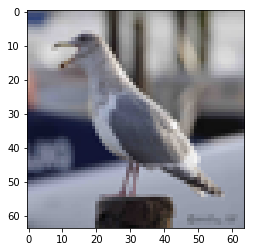

In [18]:
plt.imshow(dataset[3456])

### Train Test Split

Use more data in the train test, because there is to few data in the first place

In [40]:
shuffle = np.random.permutation(len(data_dict))
test_data = dataset[shuffle[:100]]
train_data = dataset[shuffle[100:]]

## TEXTS

In [21]:
f_files = open("CUB_200_2011/CUB_200_2011/images.txt",'r')

In [22]:
#n_pix_test = 0
n_pix= 0
for file in f_files.readlines():
    pic = file.split(' ')[1]
    text_file = open(data_path_texts+pic[:-4]+'txt','r')
    if pic[:-4] in black_and_white:
        continue
    data_texts.append([])
    for i in text_file.readlines():
        data_texts[n_pix].append(i)
    n_pix+=1

In [23]:
data_texts[0]

['light tan colored bird with a white head and an orange beak.\n',
 'the bird has a very thick, curved, and beige beak\n',
 'this bird has a long neck that is grainy and a pastel orange/blue narrow beak that droops down at the tip\n',
 'this bird is light brown, has a long hooked bill, and looks dumb.\n',
 'this large white bird has a large curved bill and a brown eye\n',
 'this bird is white with grey and has a long, pointy beak.\n',
 'this bird is white with grey and has a long, pointy beak.\n',
 'the crown of the bird is white, with light brown tones throughout.\n',
 'the crown of the bird has distinctive tones of white and brown throughout.\n',
 'this bird has a long neck and an orange bill\n']

### Tokenize and clean texts

In [33]:
tokenized_data=[]
for j in range(len(data_texts)):
    tokenized_data.append([nltk.tokenize.word_tokenize(text_prepare(i)) for i in data_texts[j] ])

In [34]:
print(tokenized_data[0])

[['light', 'tan', 'colored', 'white', 'head', 'orange', 'beak'], ['thick', 'curved', 'beige', 'beak'], ['long', 'neck', 'grainy', 'pastel', 'orange', 'blue', 'narrow', 'beak', 'droops', 'tip'], ['light', 'brown', 'long', 'hooked', 'bill', 'looks', 'dumb'], ['large', 'white', 'large', 'curved', 'bill', 'brown', 'eye'], ['white', 'grey', 'long', 'pointy', 'beak'], ['white', 'grey', 'long', 'pointy', 'beak'], ['crown', 'white', 'light', 'brown', 'tones', 'throughout'], ['crown', 'distinctive', 'tones', 'white', 'brown', 'throughout'], ['long', 'neck', 'orange', 'bill']]


### Join tokens into sequences

In [35]:
for i in range(len(tokenized_data)):
    for j in range(len(tokenized_data[i])):
        tokenized_data[i][j]= ' '.join(tokenized_data[i][j])

In [36]:
print(tokenized_data[0])

['light tan colored white head orange beak', 'thick curved beige beak', 'long neck grainy pastel orange blue narrow beak droops tip', 'light brown long hooked bill looks dumb', 'large white large curved bill brown eye', 'white grey long pointy beak', 'white grey long pointy beak', 'crown white light brown tones throughout', 'crown distinctive tones white brown throughout', 'long neck orange bill']


In [38]:
data = np.array(tokenized_data)

In [41]:
test = data[shuffle[:100]]
train = data[shuffle[100:]]

In [46]:
MAX_WORDS = 5000

### Text to sequences

In [49]:
# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_WORDS,) #filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
tokenizer_inputs.fit_on_texts(train.reshape(((len_dict-100)*10,)))
input_sequences = tokenizer_inputs.texts_to_sequences(train.reshape(((len_dict-100)*10,)))
a = pad_sequences(input_sequences,maxlen=25)
# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)

Found 6396 unique input tokens.


In [50]:
a.reshape(11680,10,25)[0]

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 14, 19, 33,
        10,  8,  9,  2, 35, 12,  1, 17, 20],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  8,  9,  2, 11, 20],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0, 36, 19, 32, 10,  9],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  1, 13,  2, 19],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 23,  9, 16, 33,  1, 13,  2, 21],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  7,  3, 10, 35, 19, 32],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  7,  1, 10, 35, 19, 32],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  2, 35,  1, 13, 19, 33],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 

In [79]:
input_ = a.reshape(11680,10,25)

In [87]:
test_sequences = tokenizer_inputs.texts_to_sequences(test.reshape((100*10,)))
a = pad_sequences(test_sequences,maxlen=25)

In [99]:
file = open('word2idx','bw')
pickle.dump(word2idx_inputs,file)

In [102]:
file = open('word2idx','br')
a = pickle.load(file)

In [90]:
input_ = a.reshape(100,10,25)

### Data augmentation

In [60]:
augmented_pix = augment_dataset(train_data, 2)

In [67]:
len_augmented = len(augmented_pix) # 23360

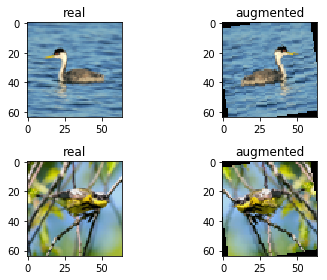

In [66]:
_,ax=plt.subplots(2,2)
ax[0,0].imshow(augmented_pix[0].squeeze())
ax[0,0].set_title('real')
ax[0,1].imshow(augmented_pix[1])
ax[0,1].set_title('augmented')
ax[1,0].imshow(augmented_pix[2].squeeze())
ax[1,0].set_title('real')
ax[1,1].imshow(augmented_pix[3])
ax[1,1].set_title('augmented')
plt.tight_layout()

In [68]:
aug_train_shuffle = np.random.permutation(len_augmented)

In [69]:
augmented_pix = np.array(augmented_pix)

In [70]:
augmented_pix = augmented_pix[aug_train_shuffle]

In [71]:
np.save('augmented_training_birds.npy',augmented_pix)

In [74]:
augmented_test = augment_dataset(test_data,2)

In [76]:
np.save('augmented_test_birds.npy',np.array(augmented_test))

In [82]:
augmented_texts = augment_dataset_text(input_,2)

In [84]:
augmented_texts = np.array(augmented_texts)

In [85]:
augmented_texts = augmented_texts[aug_train_shuffle]

In [86]:
np.save('augmented_training_birds_text.npy',augmented_texts)

In [91]:
augmented_texts = augment_dataset_text(input_,2)

In [92]:
augmented_texts = np.array(augmented_texts)

In [94]:
np.save('augmented_test_birds_text.npy',augmented_texts)